# 1. Introducción del Caso

Este notebook documenta el desarrollo de un sistema analítico para la detección de anomalías en el consumo de gas de Contugas, usando datos de volumen, presión y temperatura. El objetivo es identificar patrones atípicos que permitan mejorar la eficiencia operativa, reducir riesgos y optimizar el mantenimiento de la red de distribución.
El trabajo incluye la preparación de datos, análisis exploratorio, construcción y evaluación de modelos de machine learning no supervisados, y la visualización de resultados en un dashboard accesible para usuarios operativos.

# **Parte 1. Exploración, Preparación de Datos, Implementación de Modelos y Validación Experimental**

# 1. Preparación de Datos

**Importación de Librerías**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
sns.set_theme(style="whitegrid")

# 2. Exploración de los Datos

## 1. Lectura del archivo

In [ ]:
# Leer todas las hojas del archivo en un diccionario de DataFrames
file_id = "1TXHFNBMsWcMQ3_x60bMu1P3nvehY4WMm"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
response = requests.get(url)
hojas = pd.read_excel(io.BytesIO(response.content),sheet_name=None)

## 2. Validacion y consistencia de datos
En esta etapa se busca encontrar valores inconsistentes y hacer una limpieza del banco de datos

Se realiza inicialmente un ajuste a los datos para que todo los clientes queden en un solo Dataframe con la columna del cliente para identificarlo rapidamente.

In [ ]:
# Concatenar todas las hojas en un solo DataFrame
# Agregamos una columna 'Cliente' con el nombre de la hoja para identificar a cada cliente
datos_completos = pd.concat([df.assign(Cliente=nombre) for nombre, df in hojas.items()])

# Convertir la columna 'Fecha' a formato de fecha
datos_completos['Fecha'] = pd.to_datetime(datos_completos['Fecha'], errors='coerce')

# Tamano del dataframe
filas, columnas = datos_completos.shape
print("La fuente de informacion tiene un total de", filas, "filas.")
print("La fuente de informacion tiene un total de", columnas, "columnas.")

# Mostrar los primeros registros
datos_completos.head()

La fuente de informacion tiene un total de 847960 filas.
La fuente de informacion tiene un total de 5 columnas.


Fecha    Presion  Temperatura    Volumen    Cliente
0 2019-01-14 00:00:00  17.732563    28.209354  20.969751  CLIENTE 1
1 2019-01-14 01:00:00  17.747776    28.518614  17.845739  CLIENTE 1
2 2019-01-14 02:00:00  17.758916    28.230191  20.975914  CLIENTE 1
3 2019-01-14 03:00:00  17.727940    27.811509  20.592299  CLIENTE 1
4 2019-01-14 04:00:00  17.746484    27.795293  21.690626  CLIENTE 1

Se valida la cantidad de registros que hay por cada cliente y ver si estan distribuidos de manera regular.

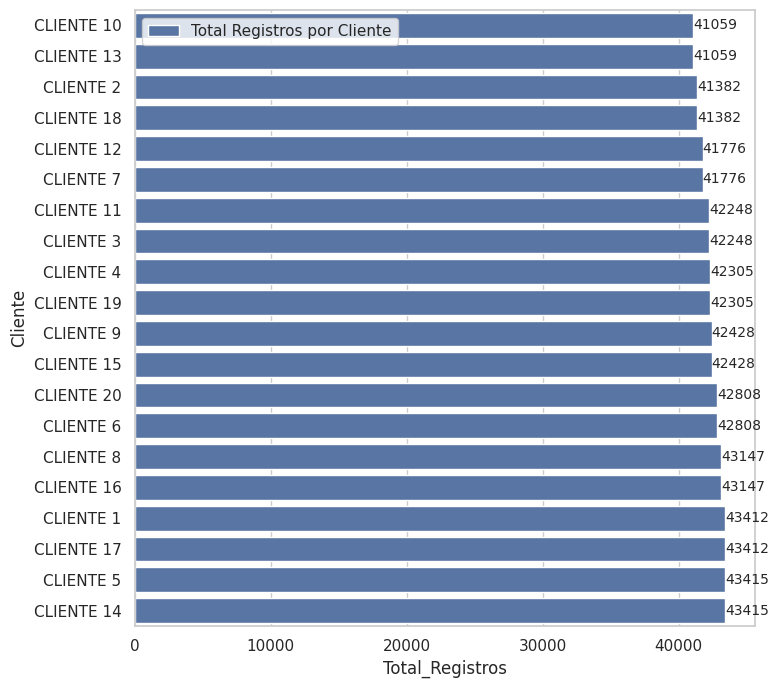

In [ ]:
df_tmp1 = datos_completos.groupby("Cliente").size().reset_index(name='Total_Registros').sort_values('Total_Registros')
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x="Total_Registros",y="Cliente",data=df_tmp1,label="Total Registros por Cliente", color="b")
ax.bar_label(ax.containers[0], fontsize=10);

Se valida si hay datos incompletos en alguna de las columnas del DataFrame

In [ ]:
datos_completos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 847960 entries, 0 to 42807
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Fecha        847960 non-null  datetime64[ns]
 1   Presion      847960 non-null  float64       
 2   Temperatura  847960 non-null  float64       
 3   Volumen      847960 non-null  float64       
 4   Cliente      847960 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 38.8+ MB


Se trata de identificar duplicados en el dataframe para hacer la su limpieza

In [ ]:
# Verificar duplicados
duplicados = datos_completos.duplicated().sum()
print(f"Registros duplicados: {duplicados}")

Registros duplicados: 0


#### Conclusion:
1. Se evidencia que hay una leve diferencia en la cantidad de registros entre cada cliente, pero hay suficientes datos para construir un modelo para cada uno.
2. No se encuentran valores nulos en ninguno de los campos.
3. El formato y consistencia de los datos (el mismo tipo de dato) se cumple en todos los registros.

## 3. Análisis Estadístico de los Datos

Se hace una primera descripcion del dataframe a nivel general.

In [ ]:
datos_completos.describe()

Fecha        Presion    Temperatura  \
count                         847960  847960.000000  847960.000000   
mean   2021-07-08 22:08:19.659418112      16.072957      25.198239   
min              2019-01-14 00:00:00       2.934873      -5.257899   
25%              2020-04-13 23:00:00      17.097350      22.693027   
50%              2021-07-07 06:00:00      17.570449      25.379859   
75%              2022-10-06 02:15:00      17.694254      27.886244   
max              2023-12-31 23:00:00      20.307852      50.019853   
std                              NaN       4.186408       3.790497   

             Volumen  
count  847960.000000  
mean       62.328206  
min         0.000000  
25%         0.000000  
50%        21.773567  
75%        99.319649  
max       577.413425  
std        80.498112

**Se detectan que hay valores nulos en el volumen**. Esto genera un primer indicio de datos atipicos en las mediciones.

In [ ]:
# Estadísticas de valores cero en 'Volumen'
valores_cero_volumen = (datos_completos['Volumen'] == 0).sum()
print(f"Registros con volumen igual a cero: {valores_cero_volumen}")

Registros con volumen igual a cero: 270660


### Analisis para el Volumen
Se realiza un boxplot para cada uno de los cliente en base a la variable Volumen.

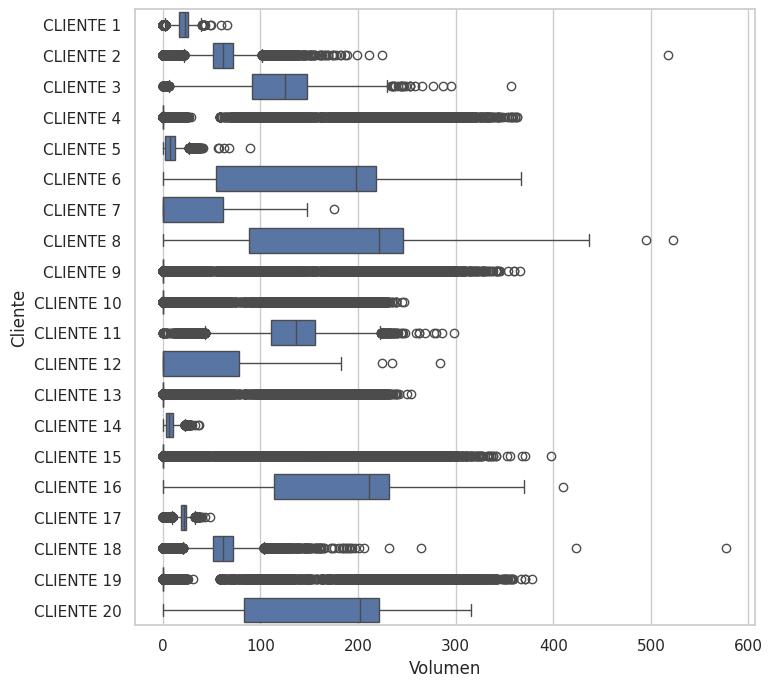

In [ ]:
fig1, ax1 = plt.subplots(figsize=(8,8))
sns.boxplot(data=datos_completos, x="Volumen", y="Cliente")
plt.show()

Se realiza un analisis de estos volumenes cero para cada uno de los clientes

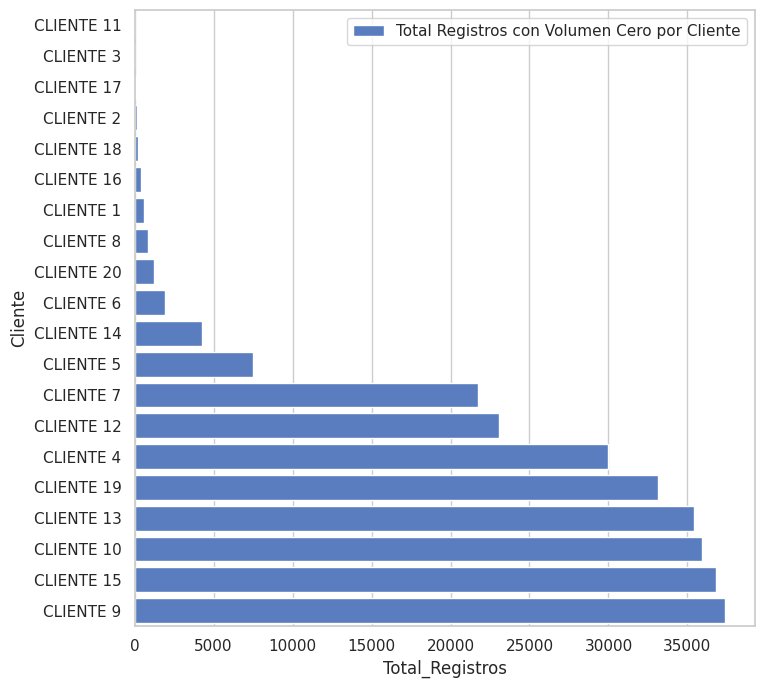

In [ ]:
df_tmp2 = datos_completos[datos_completos['Volumen'] == 0].groupby("Cliente").size().reset_index(name='Total_Registros').sort_values('Total_Registros')
fig2, ax2 = plt.subplots(figsize=(8,8))
sns.set_color_codes("muted")
ax2 = sns.barplot(x="Total_Registros",y="Cliente",data=df_tmp2,label="Total Registros con Volumen Cero por Cliente", color="b")

<Axes: xlabel='Total_Registros', ylabel='Cliente'>

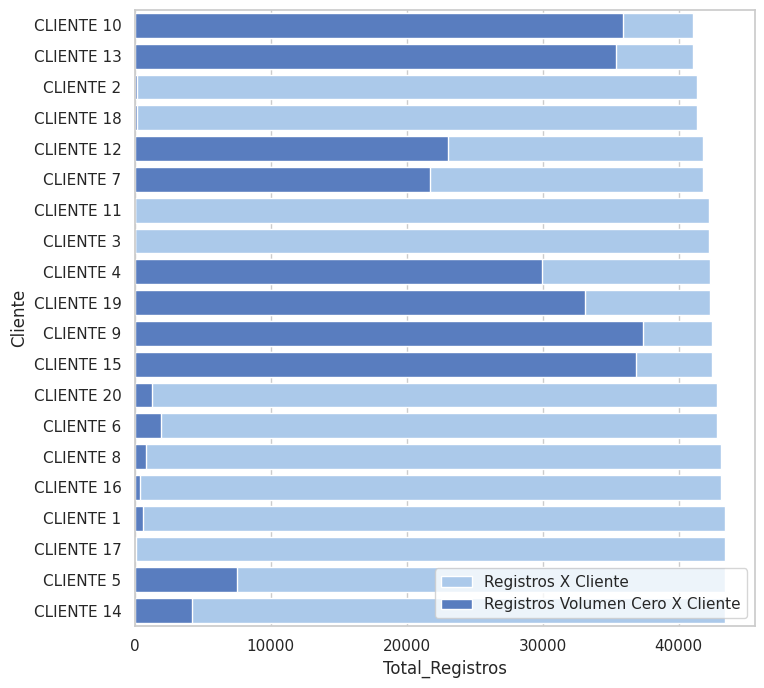

In [ ]:
df_tmp2 = datos_completos[datos_completos['Volumen'] == 0].groupby("Cliente").size().reset_index(name='Total_Registros').sort_values('Total_Registros')
fig3, ax3 = plt.subplots(figsize=(8,8))
# Grafica los registros completos
sns.set_color_codes("pastel")
sns.barplot(x="Total_Registros",y="Cliente", data=df_tmp1,label="Registros X Cliente",color="b")
sns.set_color_codes("muted")
sns.barplot(x="Total_Registros",y="Cliente",data=df_tmp2,label="Registros Volumen Cero X Cliente",color="b")

Teniendo en cuenta los hallazgos sobre clientes con volúmenes cero se realizará una depuración adicional de clientes

A partir del análisis de volumen cero por cliente y hora, se identificaron clientes con más del 80% de registros de volumen cero constante durante todo el día. Estos clientes se clasificarán como "clientes inactivos" y se excluirán del entrenamiento del modelo, para evitar sesgo y falsas detecciones de anomalías.

Para el resto de clientes, se conservarán los volúmenes cero cuando ocurren en horarios nocturnos (22h a 6h), y se eliminarán registros anómalos aislados durante horarios laborales cuando representen menos del 5% del total del cliente.


In [ ]:
# 1. Calcular la proporción de volumen cero por cliente
proporcion_volumen_cero = datos_completos.groupby('Cliente')['Volumen_Cero'].mean()

# 2. Definir clientes inactivos: más del 80% de registros con volumen cero
clientes_inactivos = proporcion_volumen_cero[proporcion_volumen_cero > 0.80].index.tolist()

print(f"Clientes inactivos detectados: {clientes_inactivos}")

# 3. Crear una nueva columna que marque si el cliente es inactivo
datos_completos['Cliente_Inactivo'] = datos_completos['Cliente'].apply(lambda x: 1 if x in clientes_inactivos else 0)

# 4. Filtrar los registros de clientes inactivos para entrenamiento del modelo
datos_entrenamiento = datos_completos[datos_completos['Cliente_Inactivo'] == 0]

# 5. Verificación
datos_entrenamiento[['Cliente', 'Volumen', 'Cliente_Inactivo']].sample(10)


Clientes inactivos detectados: ['CLIENTE 10', 'CLIENTE 13', 'CLIENTE 15', 'CLIENTE 9']


Cliente     Volumen  Cliente_Inactivo
19481   CLIENTE 1   24.056288                 0
8514    CLIENTE 4   18.153124                 0
39599   CLIENTE 8   55.480333                 0
21632  CLIENTE 17   11.253614                 0
26200  CLIENTE 17   24.142991                 0
12989   CLIENTE 3  119.459812                 0
15948  CLIENTE 12   86.443034                 0
6778   CLIENTE 11  145.524227                 0
18061  CLIENTE 14    3.931810                 0
19457   CLIENTE 5    9.477530                 0

Conteo de clientes:
Activo      16
Inactivo     4
Name: count, dtype: int64


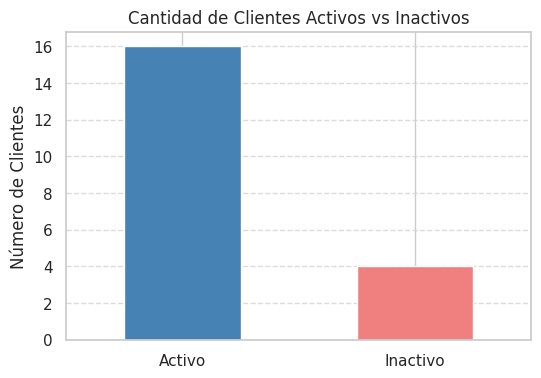

In [ ]:
import matplotlib.pyplot as plt

# Contar clientes activos e inactivos
conteo_clientes = datos_completos.groupby('Cliente')['Cliente_Inactivo'].max().value_counts()
conteo_clientes.index = ['Activo', 'Inactivo']

# Imprimir conteo
print("Conteo de clientes:")
print(conteo_clientes)

# Graficar
plt.figure(figsize=(6,4))
conteo_clientes.plot(kind='bar', color=['steelblue', 'lightcoral'])
plt.title('Cantidad de Clientes Activos vs Inactivos')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



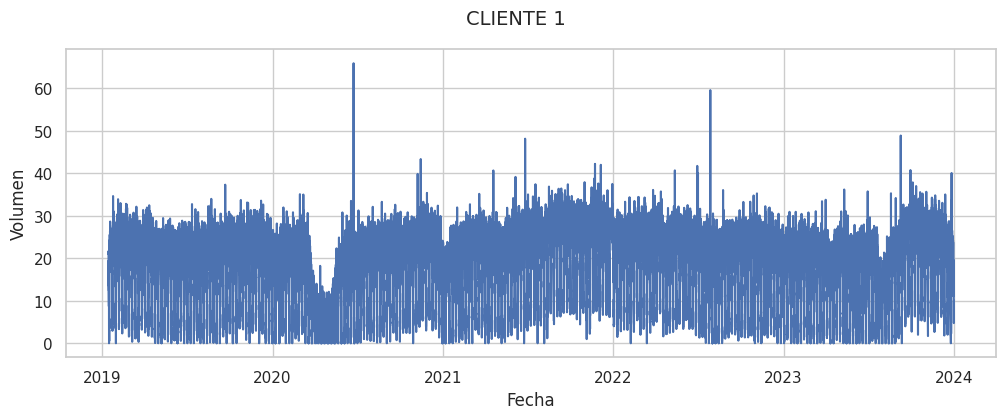

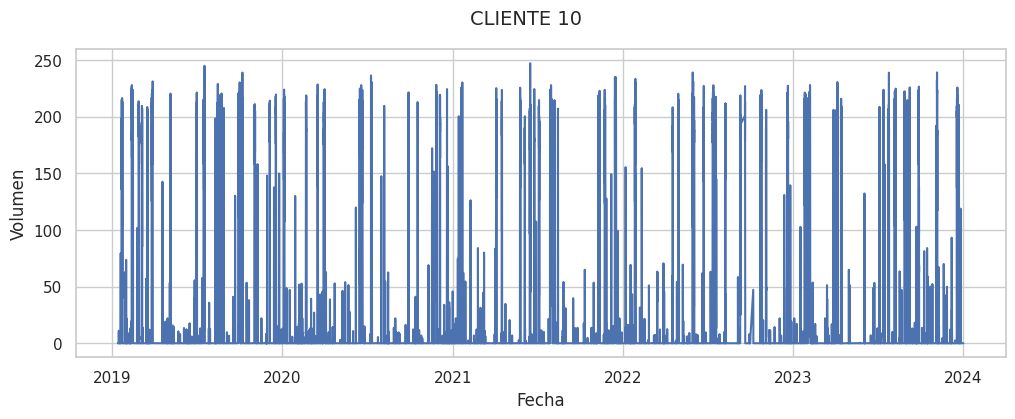

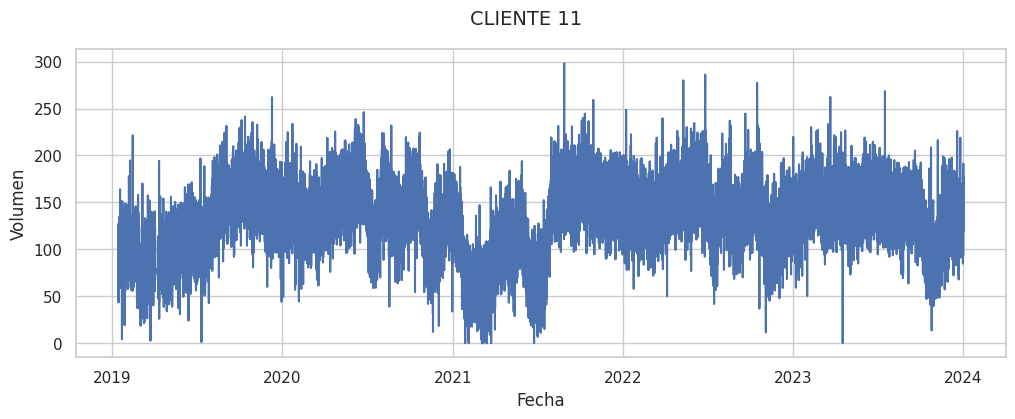

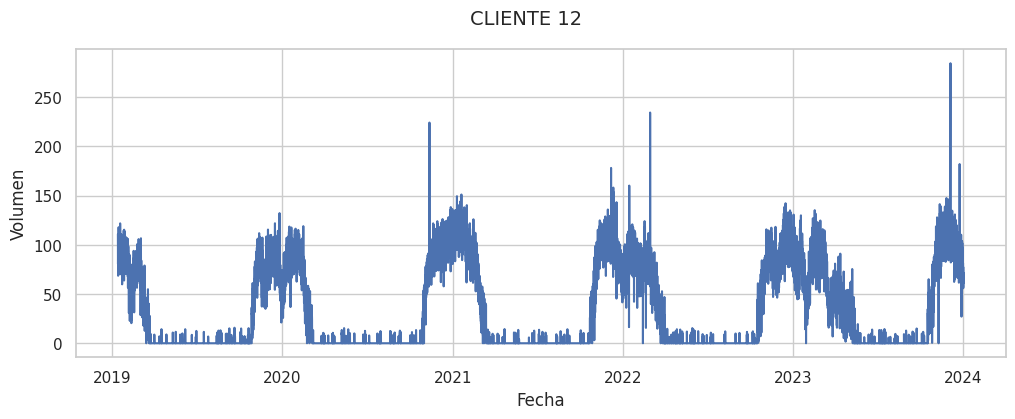

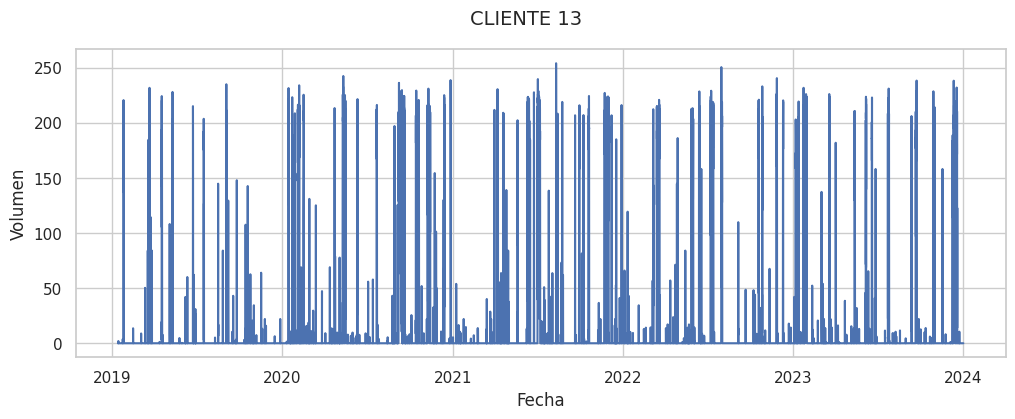

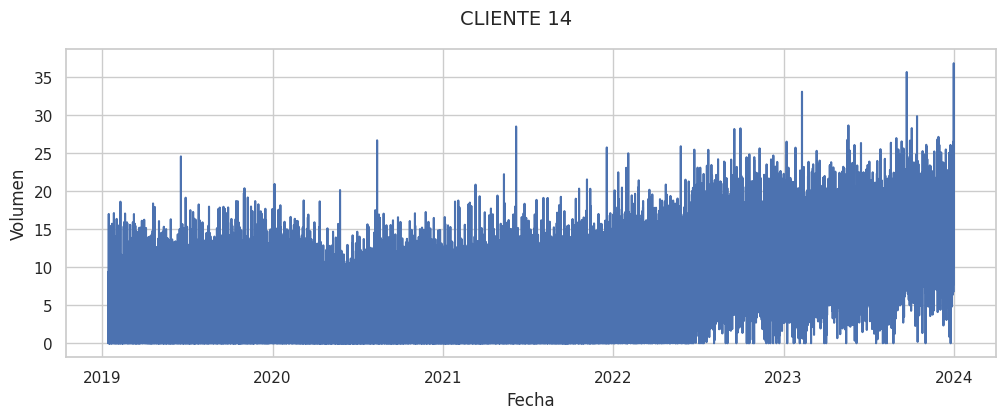

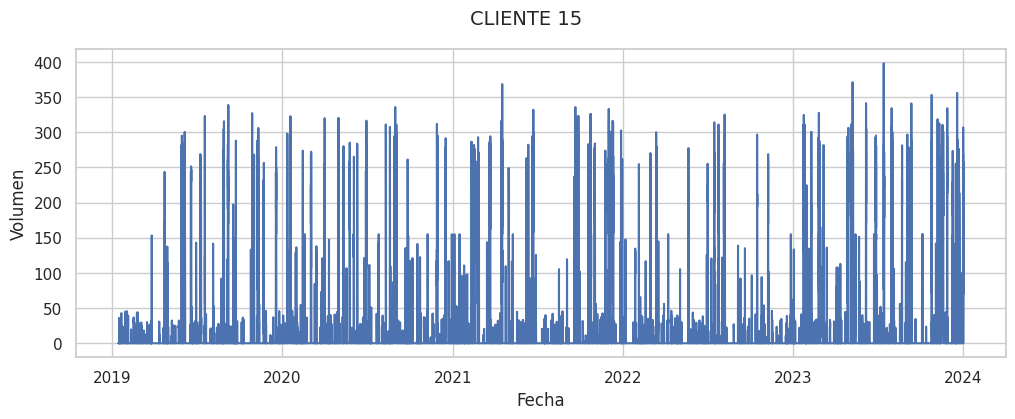

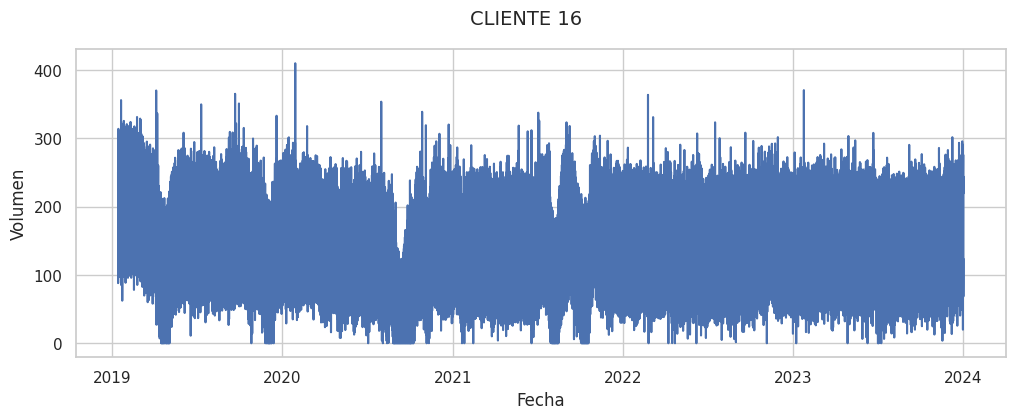

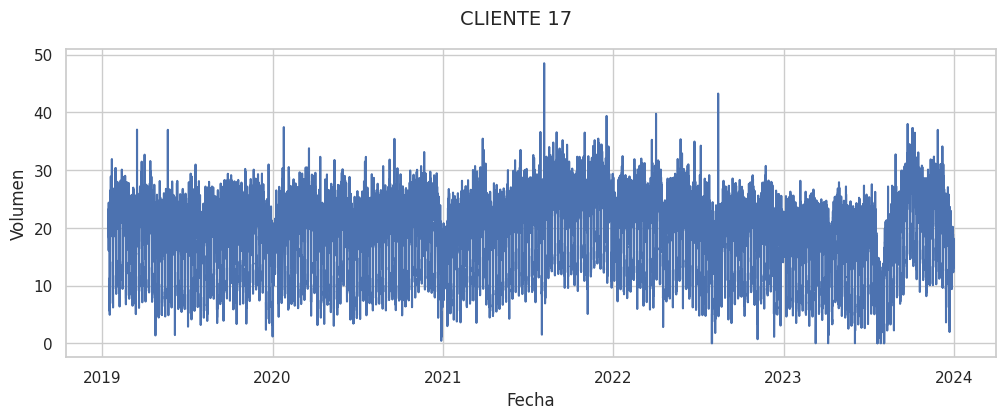

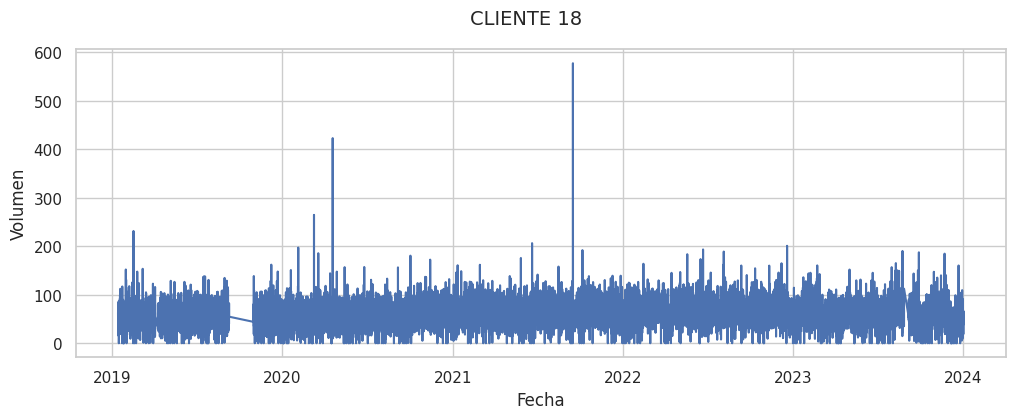

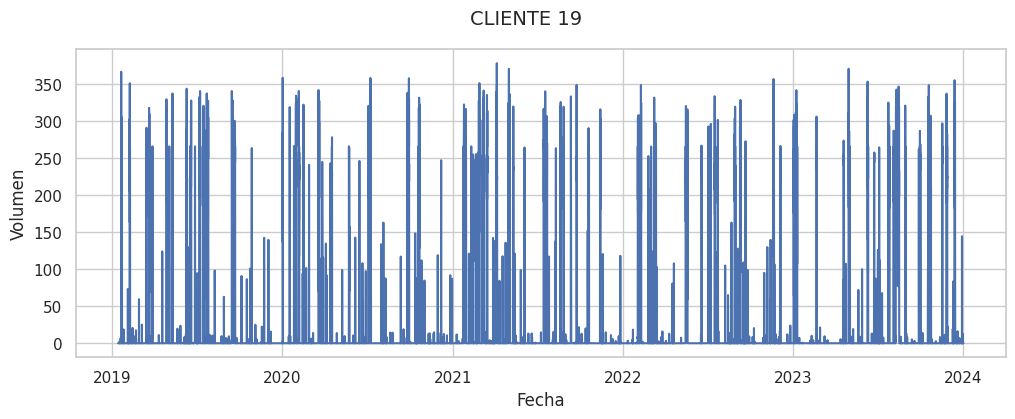

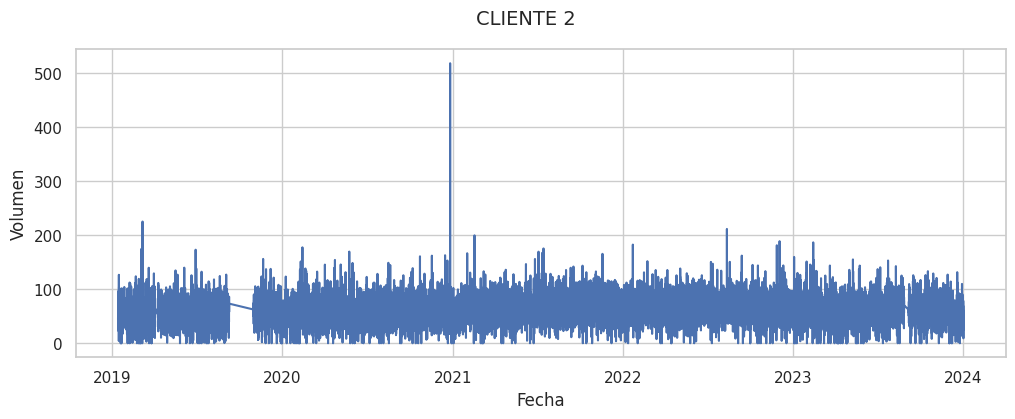

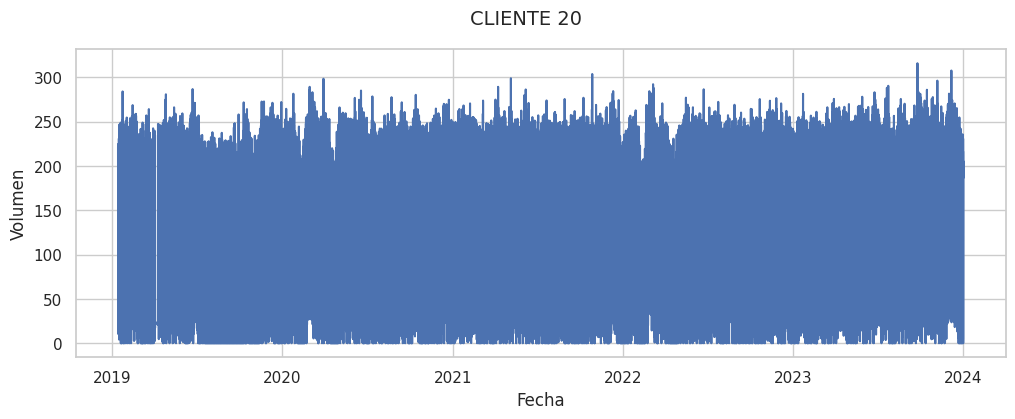

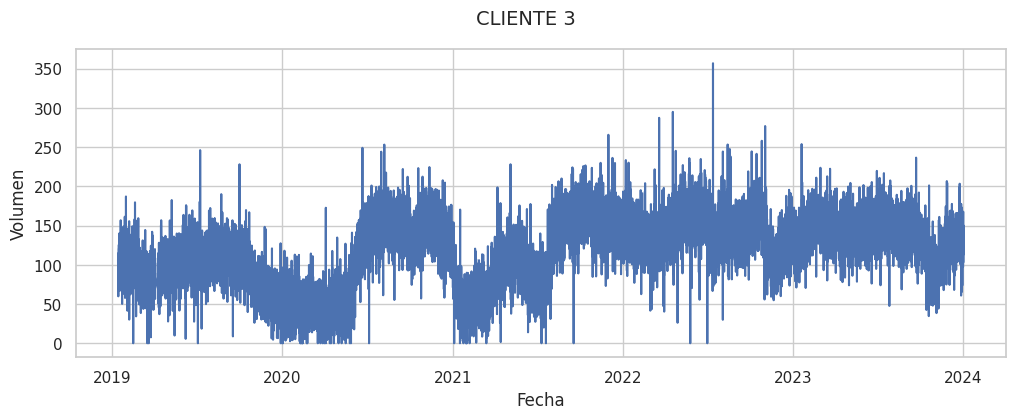

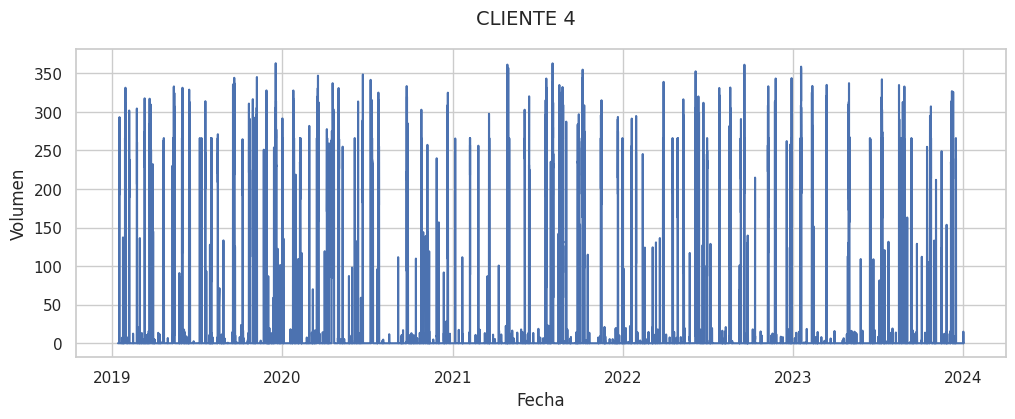

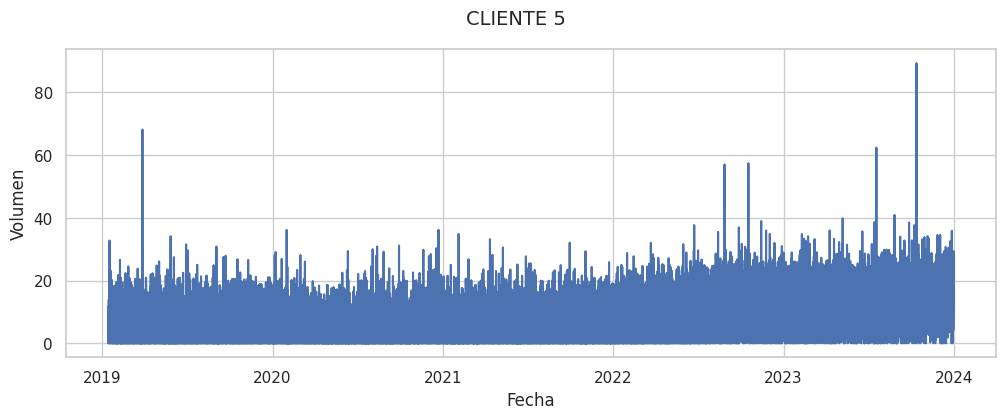

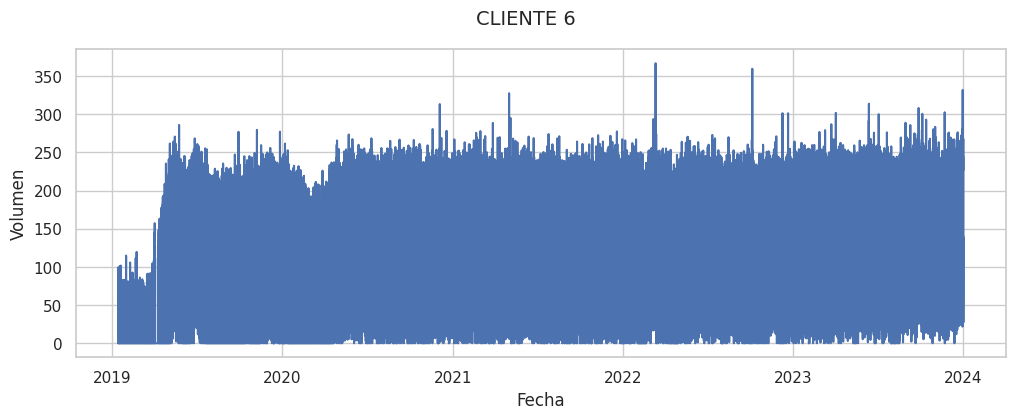

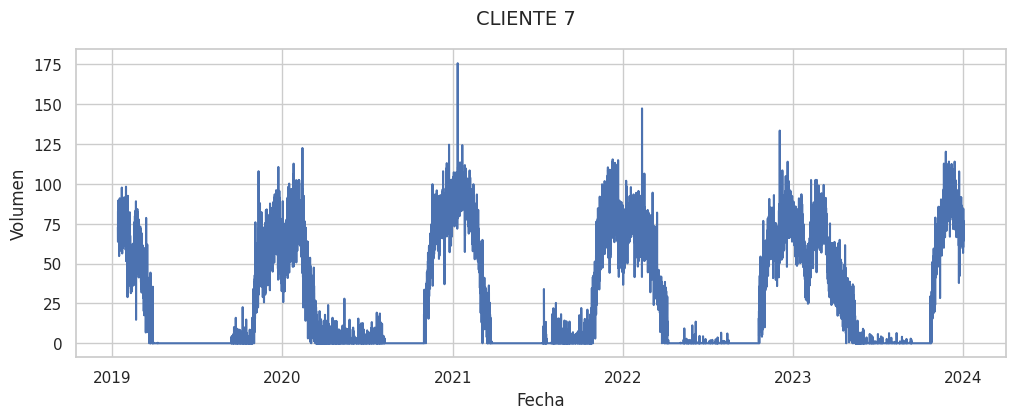

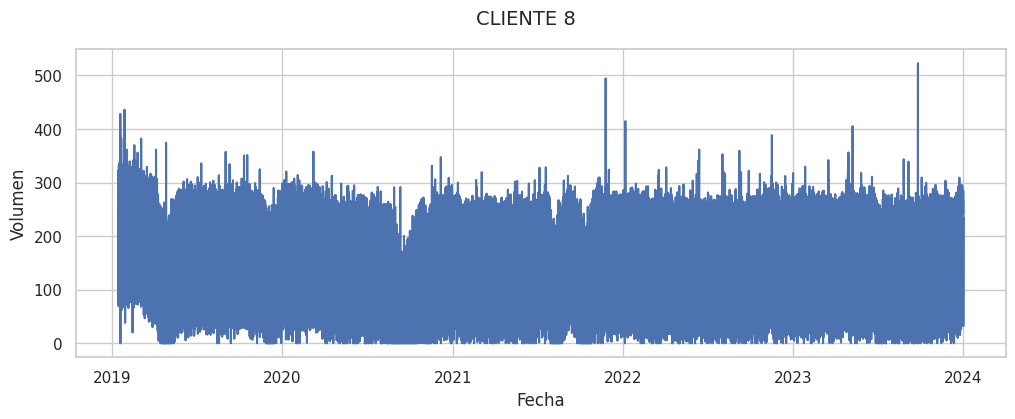

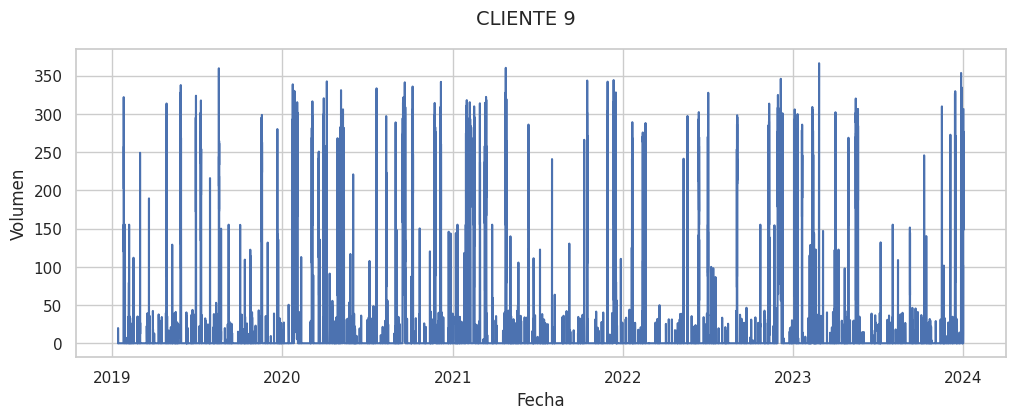

In [ ]:
for Cliente in datos_completos.groupby('Cliente'):
  df_bucle = datos_completos[datos_completos['Cliente'] == Cliente[0]]
  plt.figure(figsize=(12, 4))
  plt.suptitle(f'{Cliente[0]}', fontsize=14)
  sns.lineplot(data=df_bucle,x="Fecha",y="Volumen")

### Analisis para la temperatura
Se realiza un boxplot para cada uno de los cliente en base a la variable temperatura

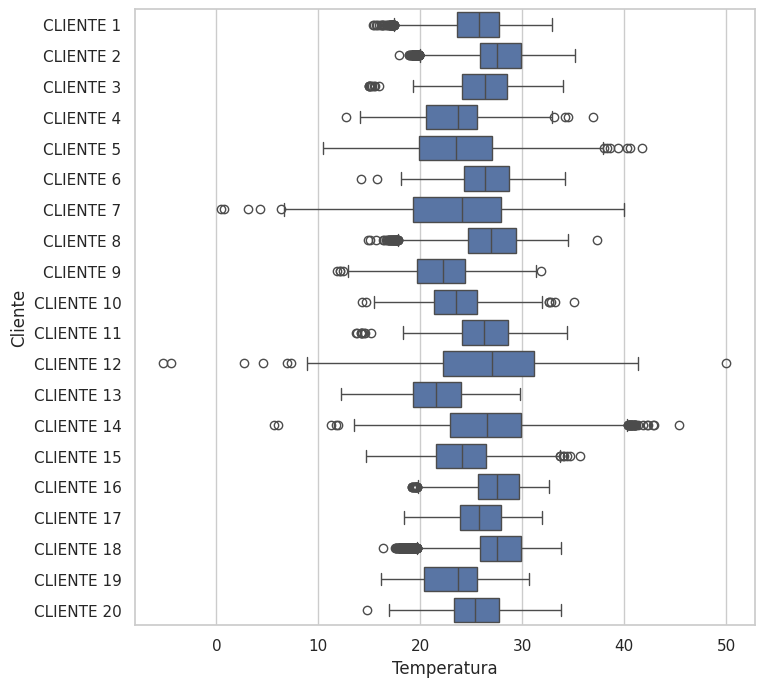

In [ ]:
fig4, ax4 = plt.subplots(figsize=(8,8))
sns.boxplot(data=datos_completos, x="Temperatura", y="Cliente")
plt.show()

Se hace un analisis temporal de la temperatura.

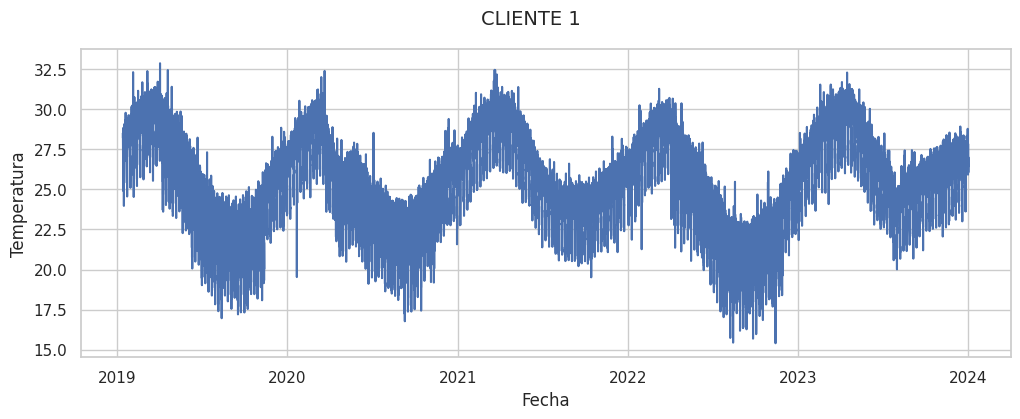

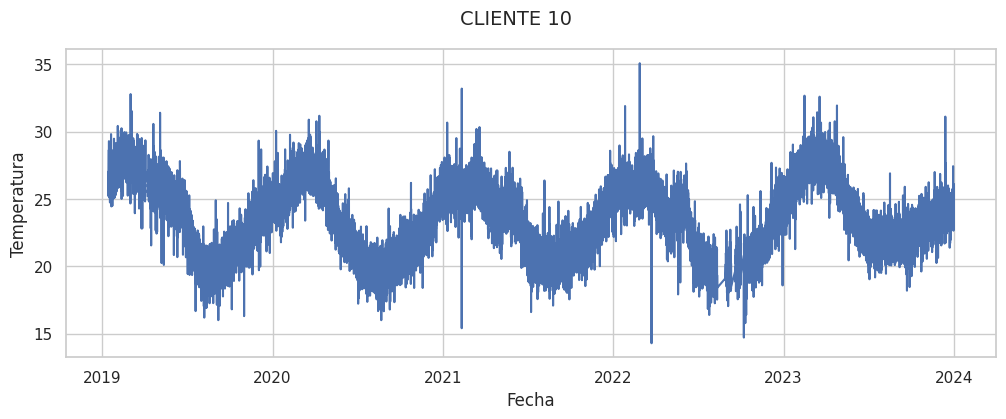

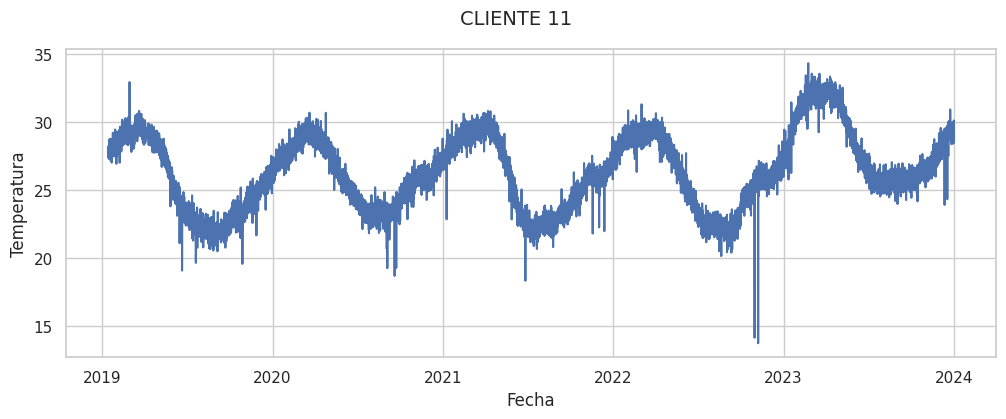

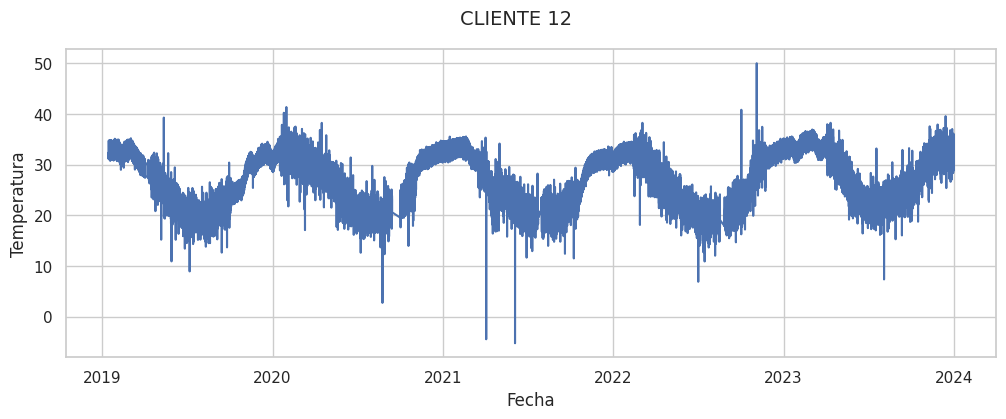

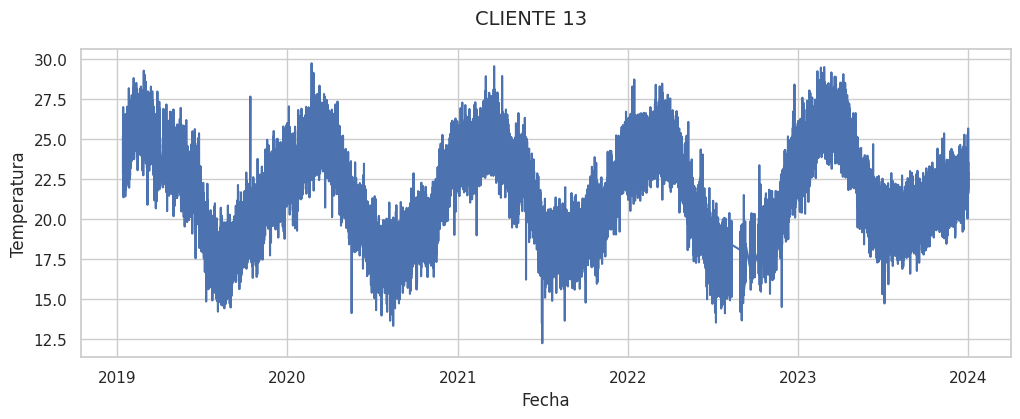

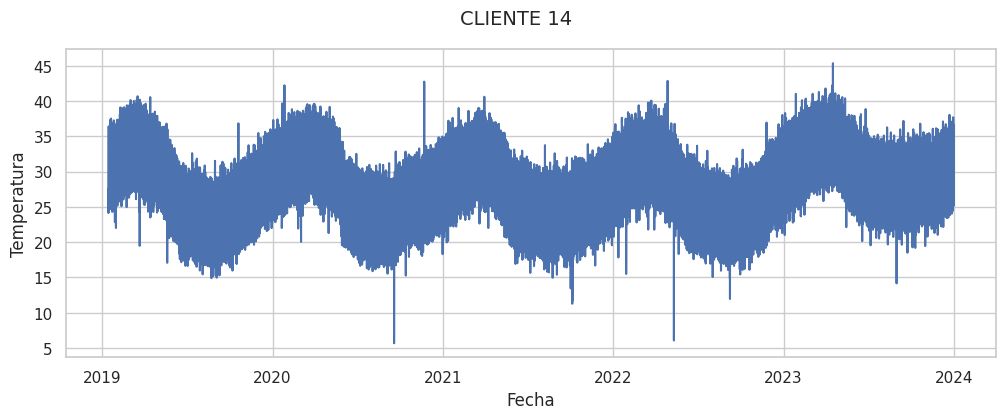

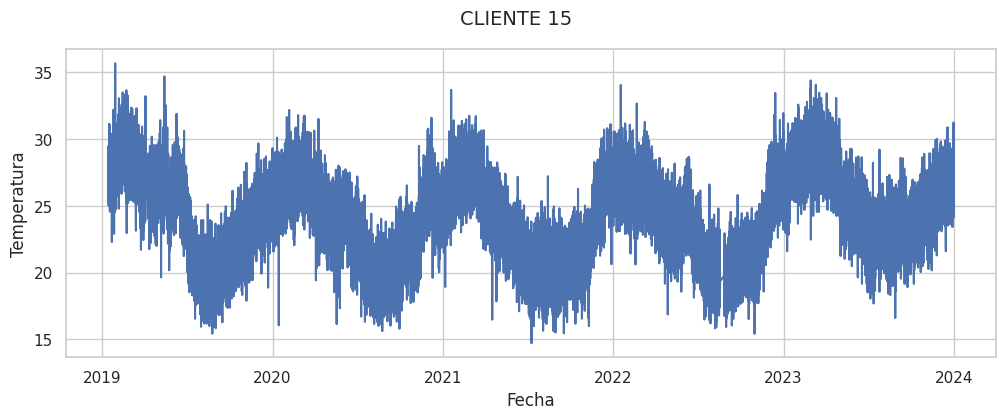

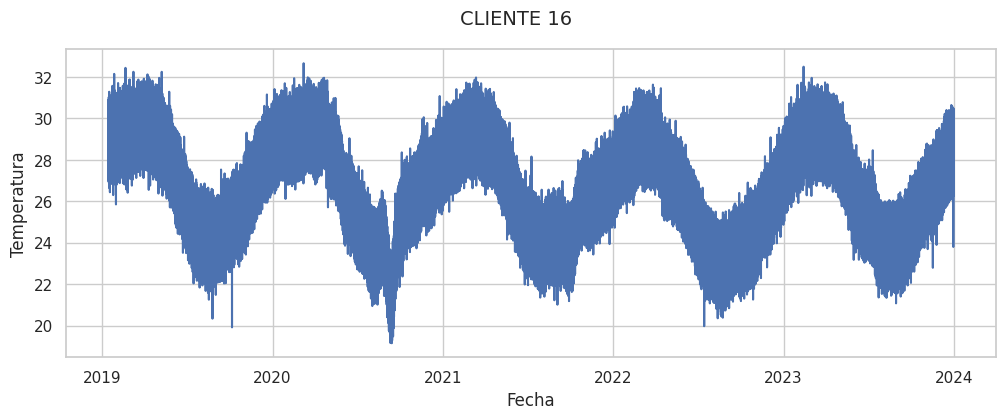

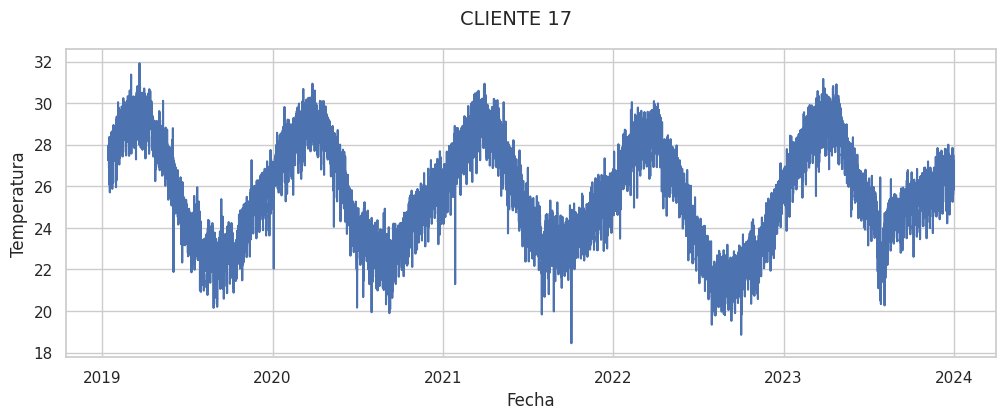

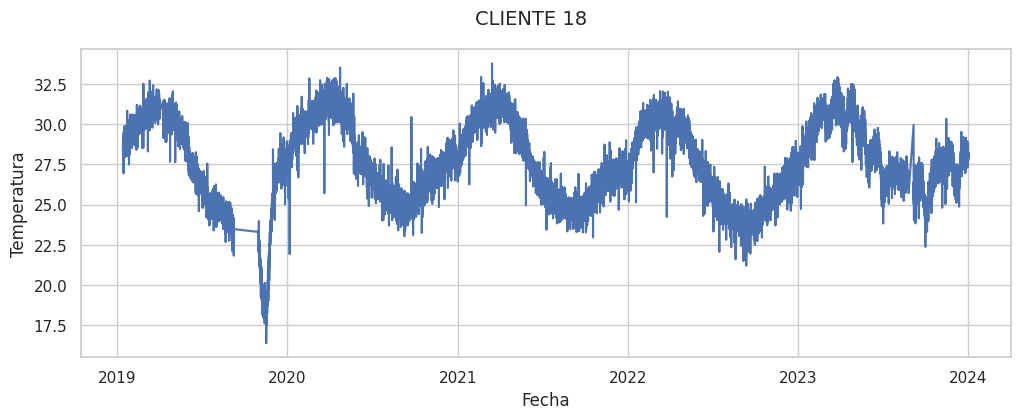

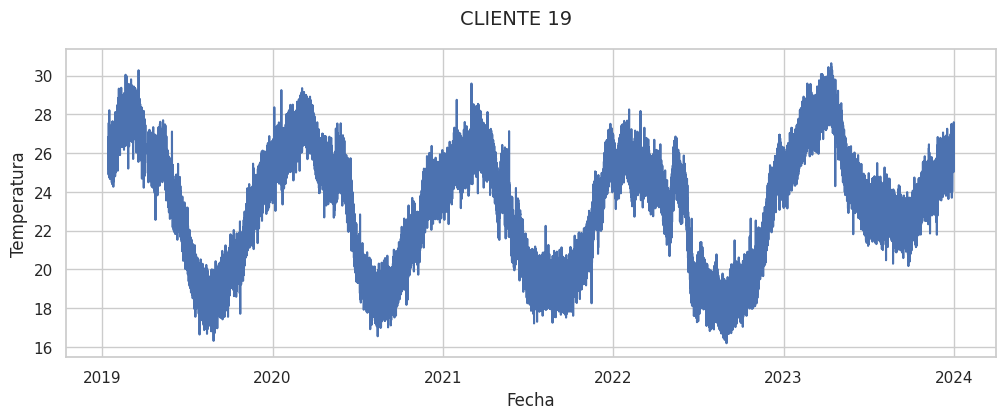

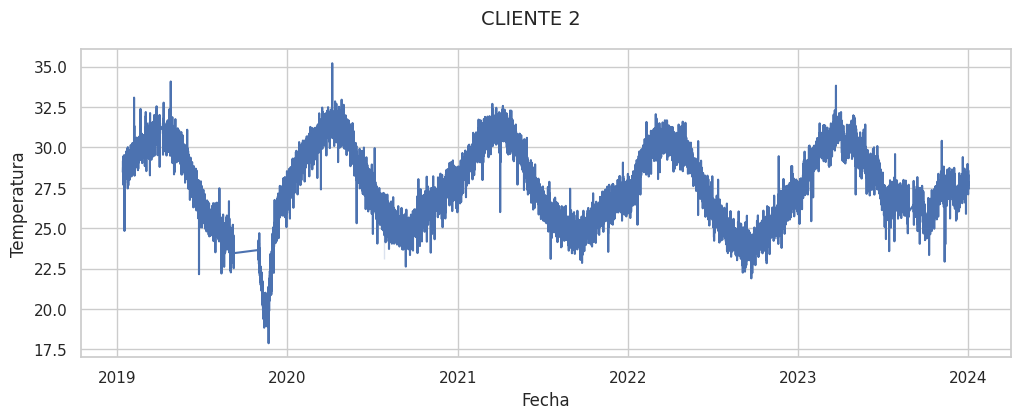

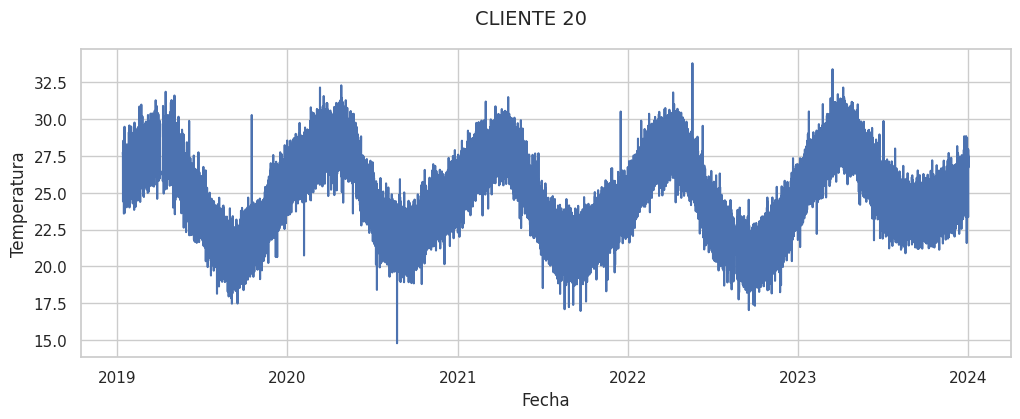

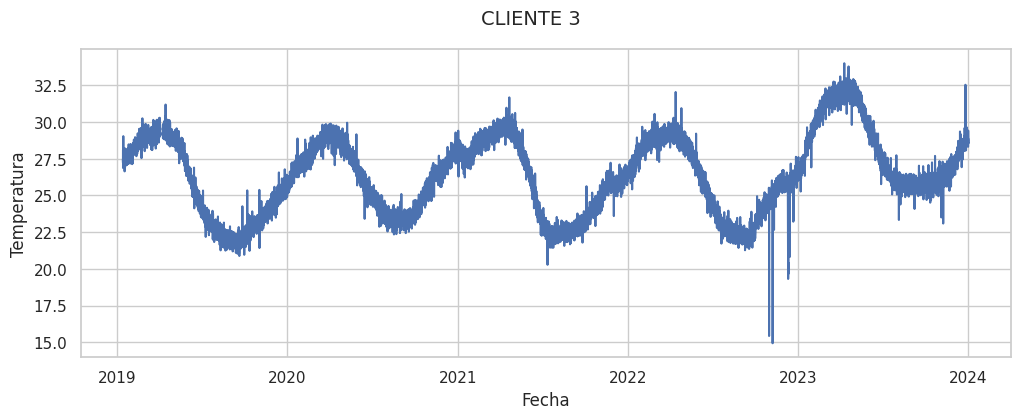

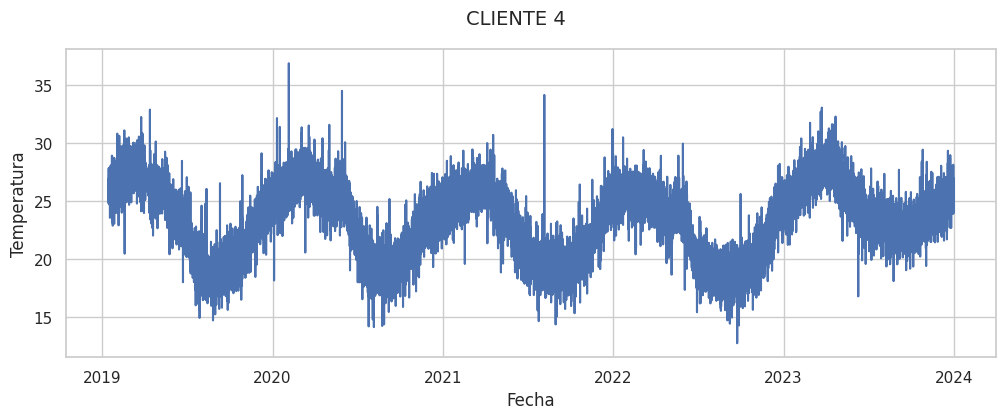

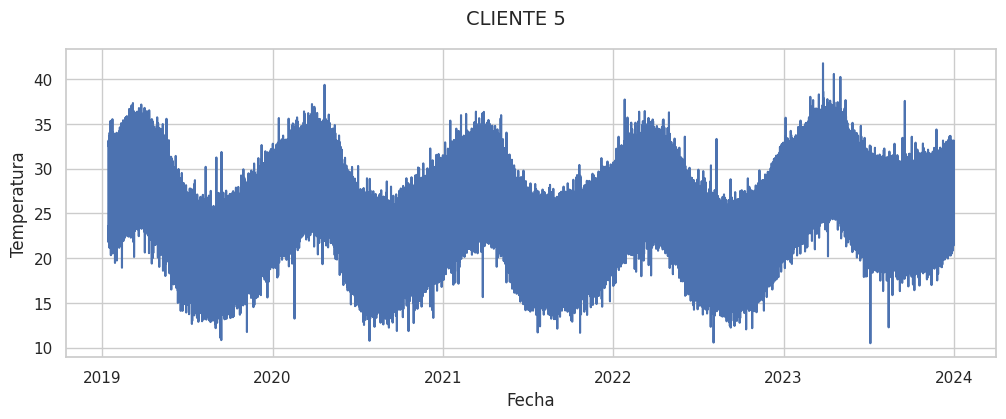

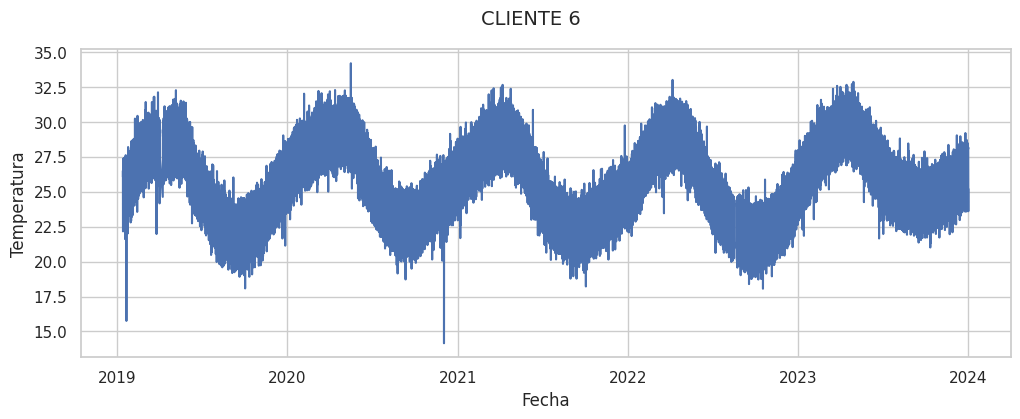

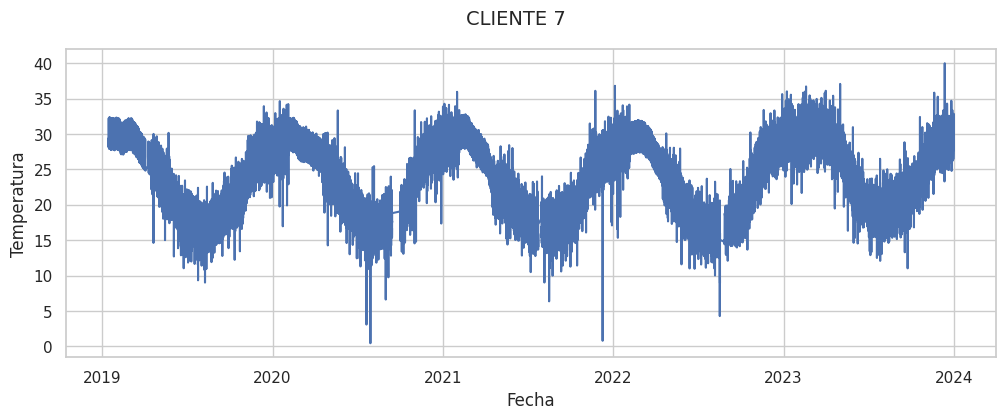

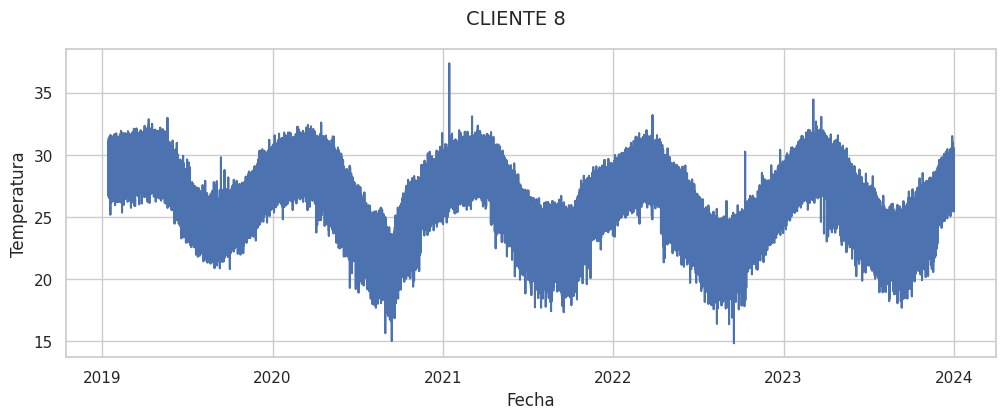

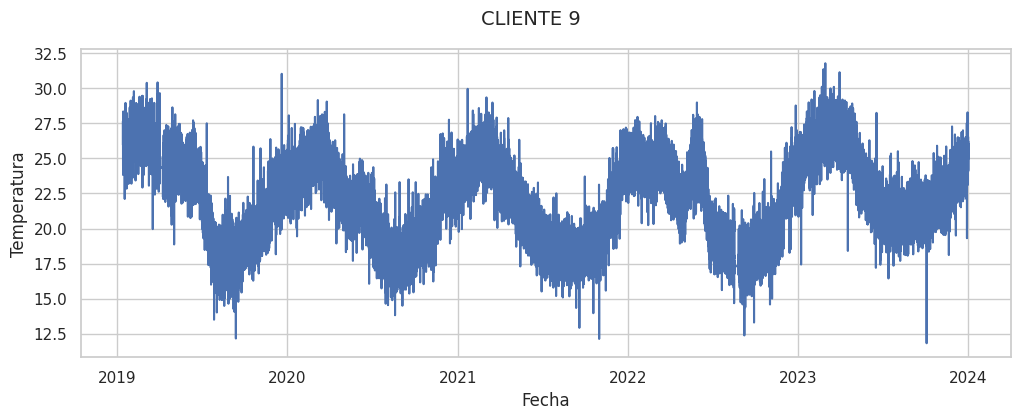

In [ ]:
for Cliente in datos_completos.groupby('Cliente'):
  df_bucle = datos_completos[datos_completos['Cliente'] == Cliente[0]]
  plt.figure(figsize=(12, 4))
  plt.suptitle(f'{Cliente[0]}', fontsize=14)
  sns.lineplot(data=df_bucle,x="Fecha",y="Temperatura")

### Analisis para la presion
Se realiza un boxplot para cada uno de los cliente en base a la variable presion.

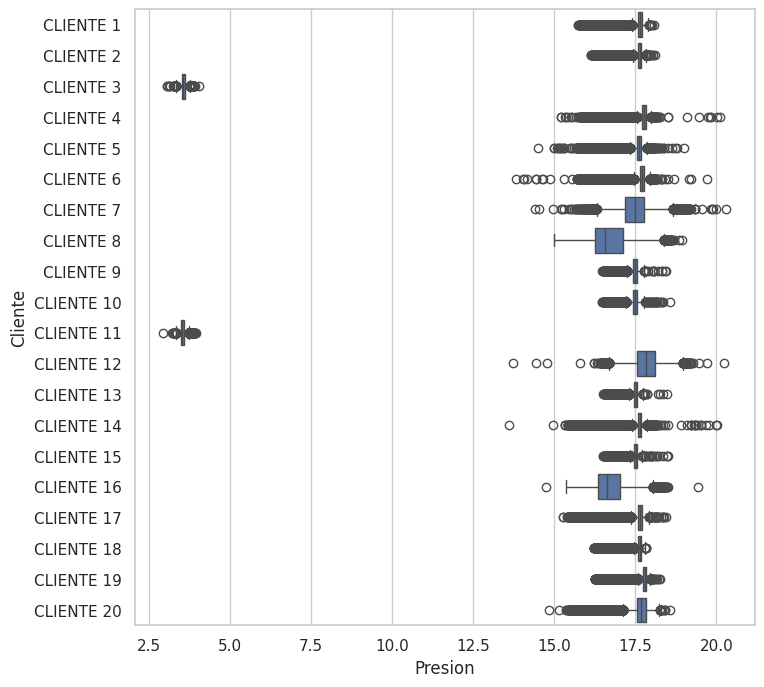

In [ ]:
fig5, ax5 = plt.subplots(figsize=(8,8))
sns.boxplot(data=datos_completos, x="Presion", y="Cliente")
plt.show()

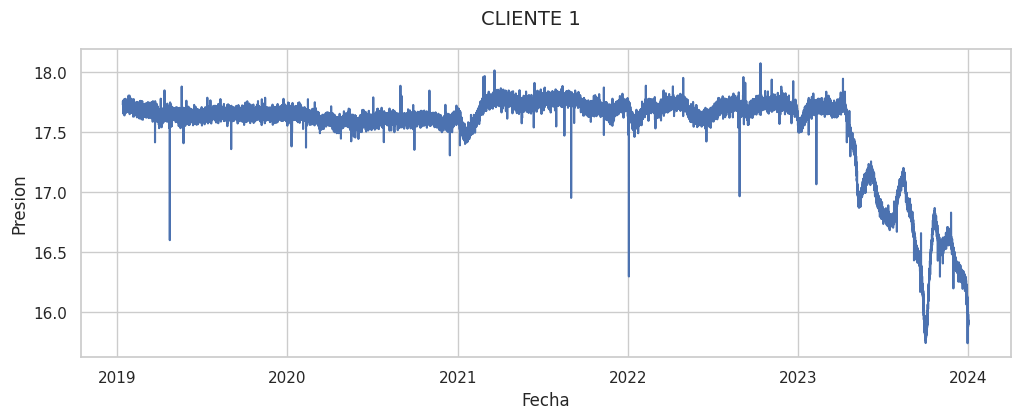

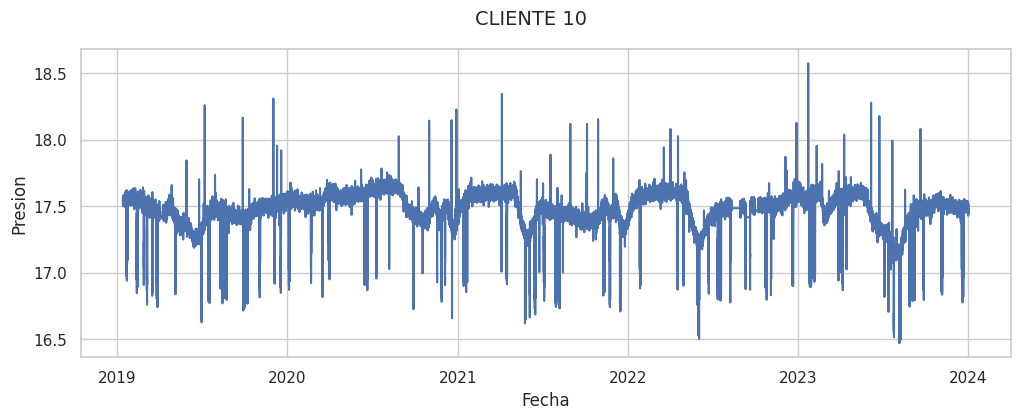

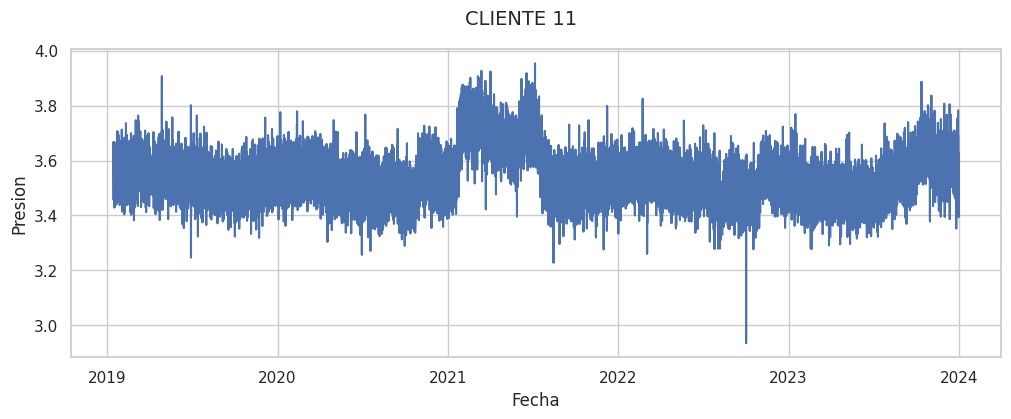

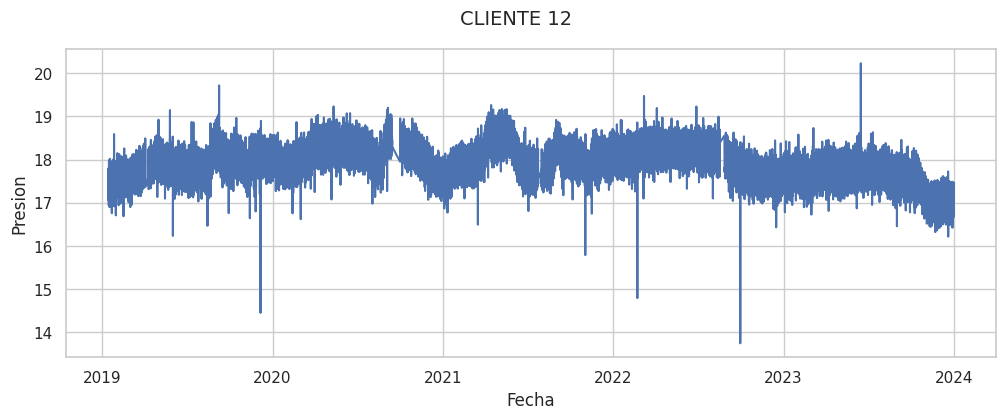

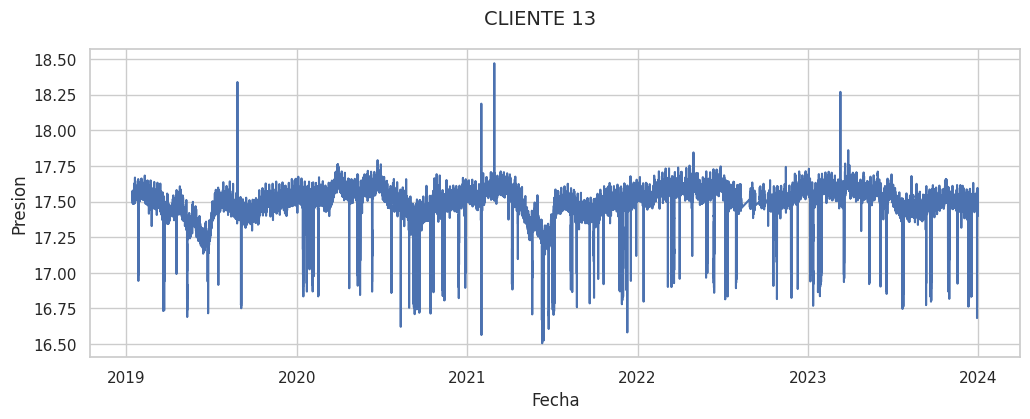

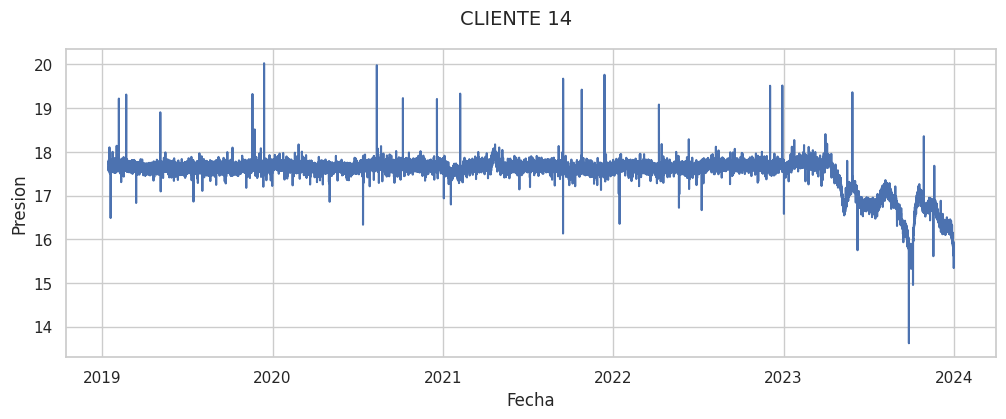

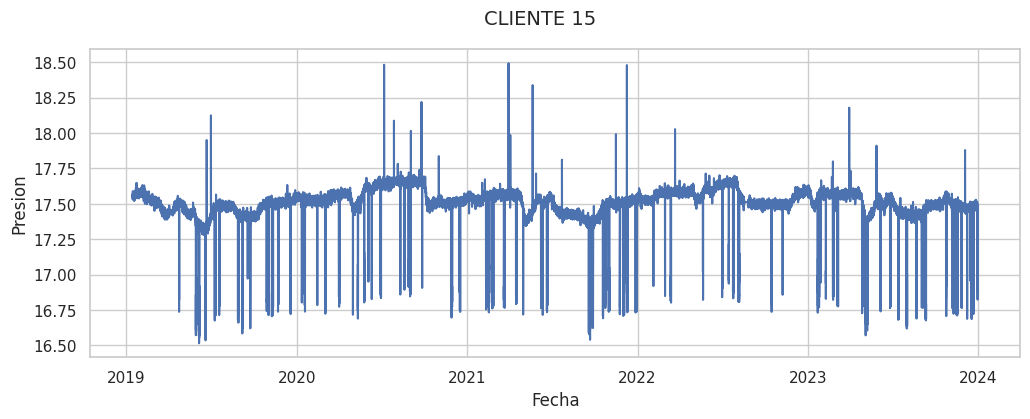

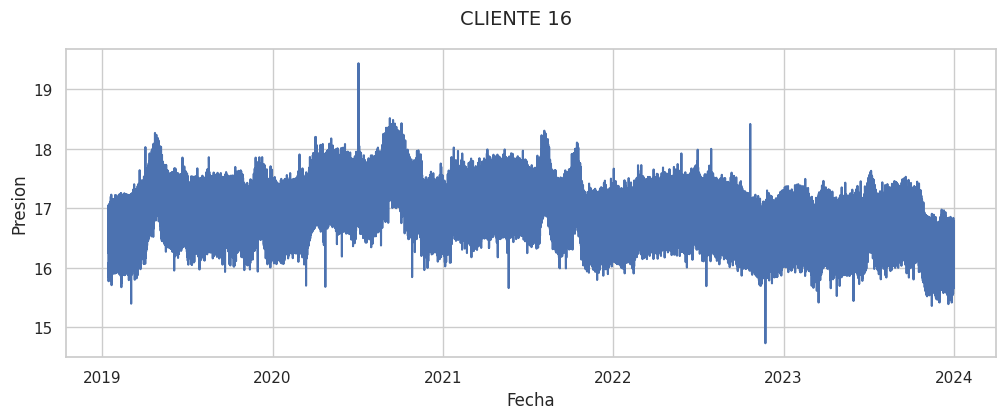

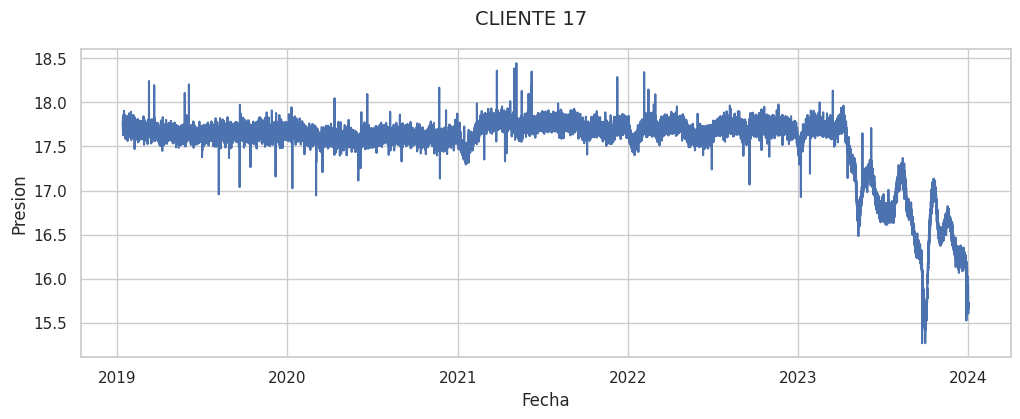

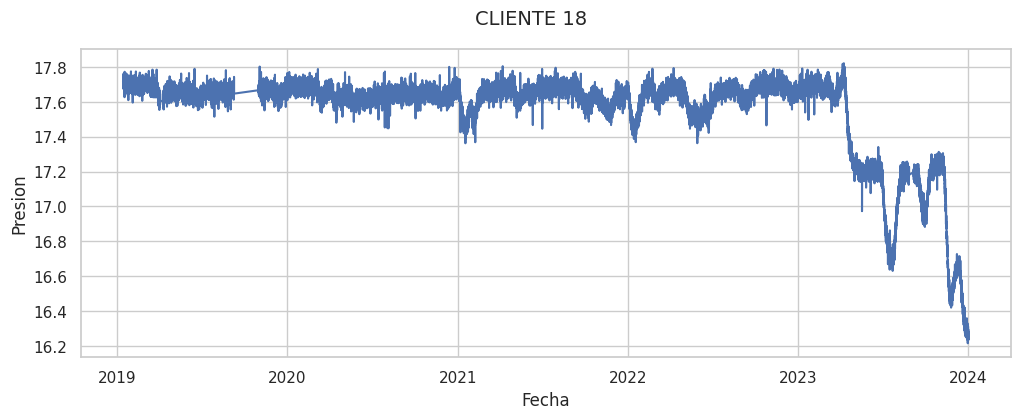

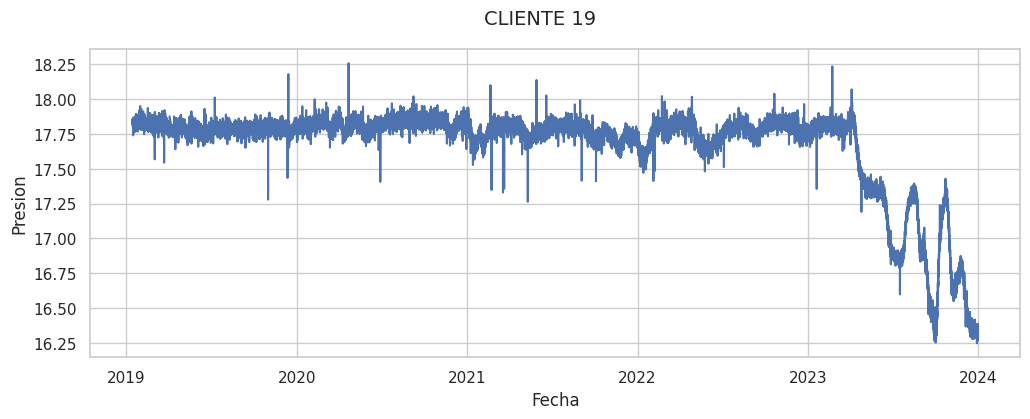

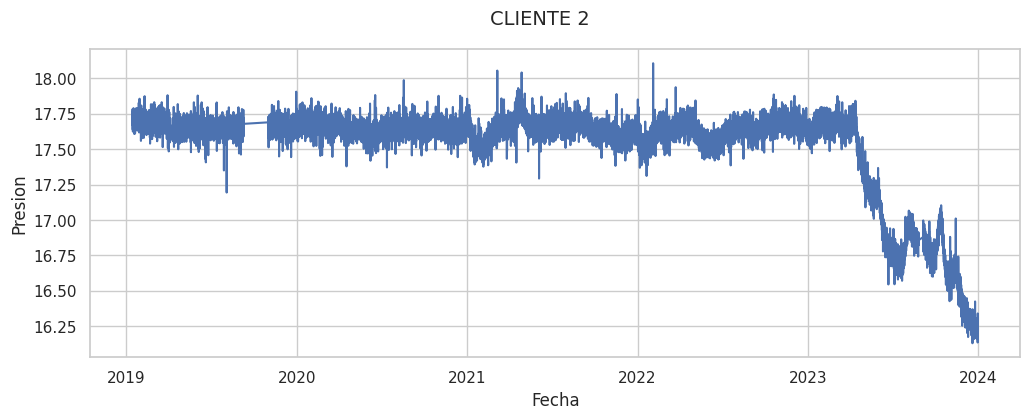

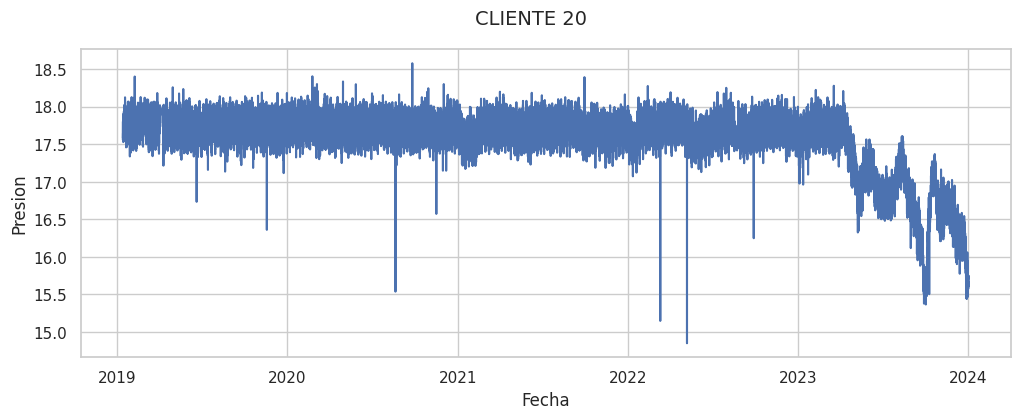

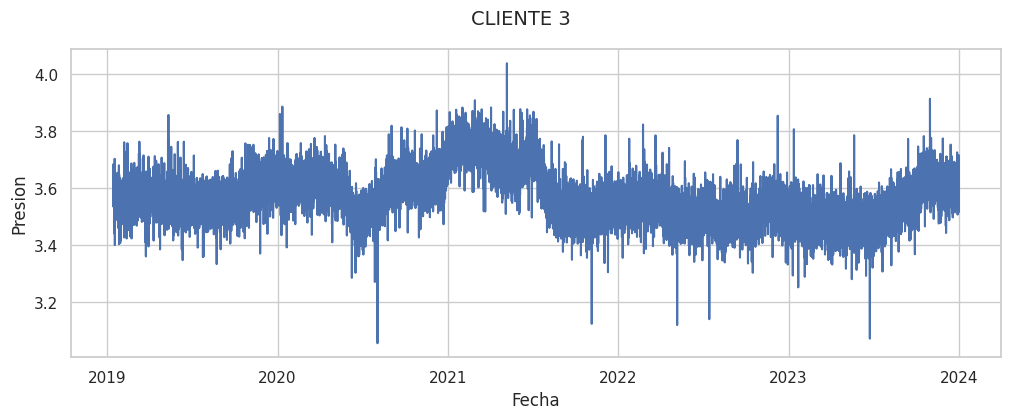

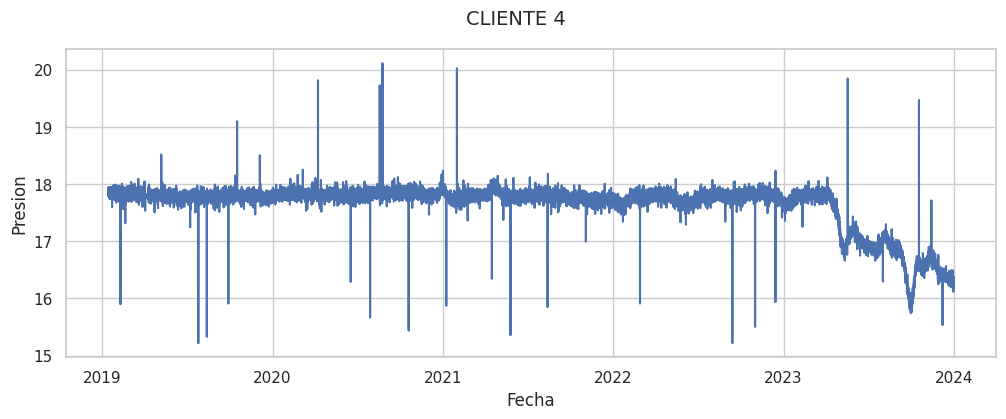

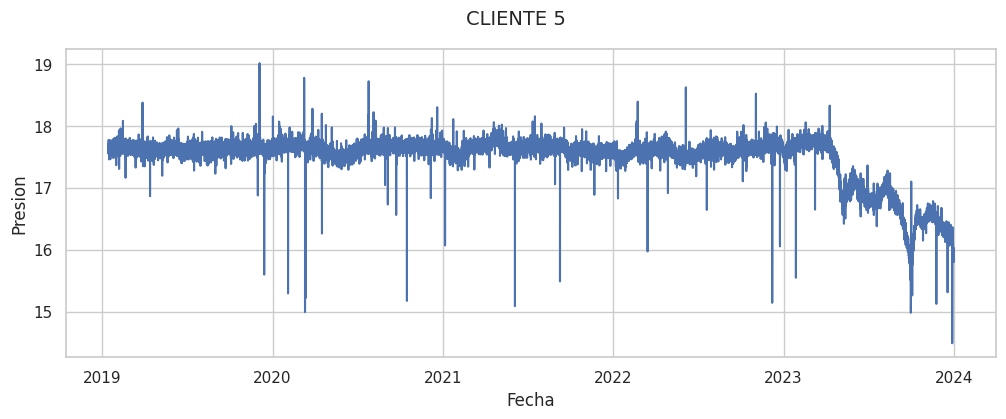

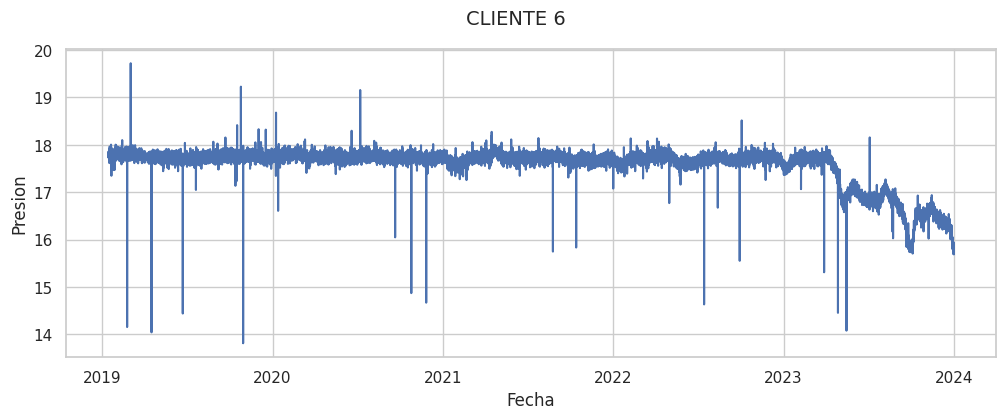

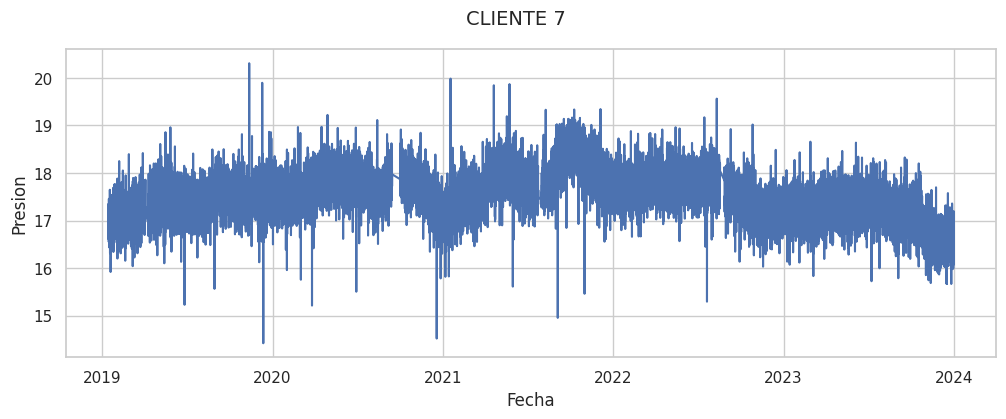

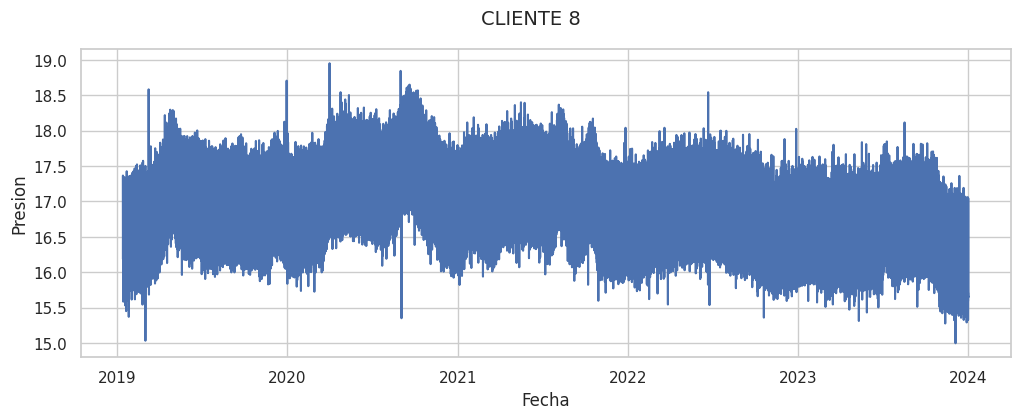

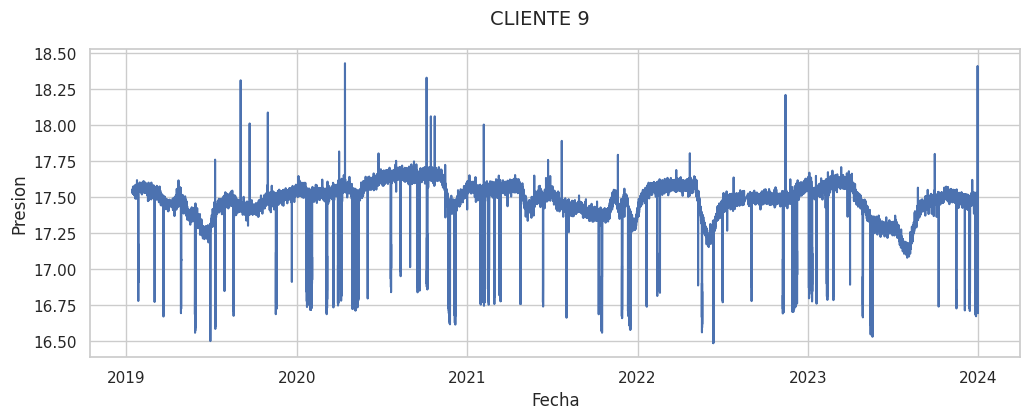

In [ ]:
for Cliente in datos_completos.groupby('Cliente'):
  df_bucle = datos_completos[datos_completos['Cliente'] == Cliente[0]]
  plt.figure(figsize=(12, 4))
  plt.suptitle(f'{Cliente[0]}', fontsize=14)
  sns.lineplot(data=df_bucle,x="Fecha",y="Presion")

#### Conclusiones
Sobre la variable Volumen:
1. Se evidencia que hay clientes que tienen muchos registros con un volumen igual a cero. Algo que es evidentemente raro.  

Sobre la variable Temperatura:
1. Se evidencia tambien registros con temperaturas negativas, **PERO** es importante tener en cuenta que en un ducto de gas puede llegar a ser normal por las sigueintes razones:
  * __Efecto Joule-Thomson:__  
Si el gas pasa por una válvula de regulación de presión justo antes de llegar al cliente (muy común), la expansión del gas puede causar enfriamiento. Eso puede llevar la temperatura por debajo de 0°C.
  * __Ambiente externo:__  
Si el ducto está expuesto o semi enterrado en zonas frías, el gas puede perder calor y bajar de 0°C, especialmente si no hay calefacción o aislamiento térmico.
  * __Velocidad del flujo:__  
En sistemas de alta velocidad de flujo, el gas puede no tener tiempo de calentarse por el entorno, manteniéndose frío si viene de un tramo previamente frío.
  * __Falta de precalentamiento:__  
No todos los puntos de entrega de gas tienen calentadores. A veces, el gas simplemente llega tal como viene del sistema de distribución.
2. Para los clientes 5, 7, 12 y 14 se observa una mayor variacion de la temperatura, con un rango de datos mas amplios y dispersos.
3. Para esta variable se observa claramente una variacion temporal ciclica y estacional en la cual los primeros pmeses hay un incremento teniendo el mayor valor; mientras que para finales de año se realiza la disminucion del calor.
Esta variacion corresponde mucho al cambio de temperatura en Peru el cual presenta el mismo ciclo.

Sobre la variable Presion:
1. Se evidencia que hay dos clientes (Clientes 3 y 11) que tienen un comportamiento diferente, ya que su distribucion se encuentra centrada en un valor diferente a los demas.

# 3. Creacion de datos para Modelos

## Primer Dataset
Para este primer conjunto de datos se crearan las columnas:
* *mes_sin* -> Es el numero del mes de la fecha de lectura de la medida aplicando la transformacion Seno.
* *mes_cos* -> Es el numero del mes de la fecha de lectura de la medida aplicando la transformacion Coseno.
* *dia_semana_sin* -> Es el numero del dia de la fecha de lectura de la medida aplicando la transformacion Seno.
* *dia_semana_cos* -> Es el numero del dia de la fecha de lectura de la medida aplicando la transformacion Coseno.
* *hora_sin* -> Es el numero de la hora (0-23) de la fecha de lectura de la medida aplicando la transformacion Seno.
* *hora_cos* -> Es el numero de la hora (0-23) de la fecha de lectura de la medida aplicando la transformacion Coseno.  

Por lo tanto, se tendra como resultado un Dataframe con los siguientes campos:
* *mes_sin*
* *mes_cos*
* *dia_semana_sin*
* *dia_semana_cos*
* *hora_sin*
* *hora_cos*
* *Volumen*
* *Temperatura*
* *Presion*

**Justificacion**  
Los nuevos campos son transformacion que se aplican sobre el campo de la fecha para codificarlos. La razon para alicar la transformacion _Seno_ y _Coseno_ es en base a la _Codificacion Ciclica_ de variables (cyclical encoding) la cual es una forma de transformar variables cíclicas (como la hora, el día de la semana, o el mes) en una representación continua y circular usando funciones seno y coseno.  
¿Por qué se necesita?  
Porque variables como hora = 0 y hora = 23 están muy cerca entre sí en el tiempo, pero si se dejan como números enteros, el modelo pensará que están muy lejos (lo cual es un error).

In [ ]:
DF_Final_1 = datos_entrenamiento.copy()
## Converion para el mes
DF_Final_1['mes'] = DF_Final_1['Fecha'].dt.month
DF_Final_1['mes_sin'] = np.sin(2 * np.pi * DF_Final_1['mes'] / 12)
DF_Final_1['mes_cos'] = np.cos(2 * np.pi * DF_Final_1['mes'] / 12)
## Conversion para el dia
DF_Final_1['dia_semana'] = DF_Final_1['Fecha'].dt.dayofweek
DF_Final_1['dia_semana_sin'] = np.sin(2 * np.pi * DF_Final_1['dia_semana'] / 7)
DF_Final_1['dia_semana_cos'] = np.cos(2 * np.pi * DF_Final_1['dia_semana'] / 7)
## Conversion para la hora
DF_Final_1['hora'] = DF_Final_1['Fecha'].dt.hour
DF_Final_1['hora_sin'] = np.sin(2 * np.pi * DF_Final_1['hora'] / 24)
DF_Final_1['hora_cos'] = np.cos(2 * np.pi * DF_Final_1['hora'] / 24)
## Quita las variables que no van a estar
DF_Final_1.drop(inplace=True,axis=1,columns=['Fecha','mes','dia_semana','hora'])

In [ ]:
DF_Final_1.head()

Presion  Temperatura    Volumen    Cliente  mes_sin   mes_cos  \
0  17.732563    28.209354  20.969751  CLIENTE 1      0.5  0.866025   
1  17.747776    28.518614  17.845739  CLIENTE 1      0.5  0.866025   
2  17.758916    28.230191  20.975914  CLIENTE 1      0.5  0.866025   
3  17.727940    27.811509  20.592299  CLIENTE 1      0.5  0.866025   
4  17.746484    27.795293  21.690626  CLIENTE 1      0.5  0.866025   

   dia_semana_sin  dia_semana_cos  hora_sin  hora_cos  
0             0.0             1.0  0.000000  1.000000  
1             0.0             1.0  0.258819  0.965926  
2             0.0             1.0  0.500000  0.866025  
3             0.0             1.0  0.707107  0.707107  
4             0.0             1.0  0.866025  0.500000

Finalmente se crea un mapa de correlacion de las variables finales para identificar si no hay una correlacion fuerte entre ellas.

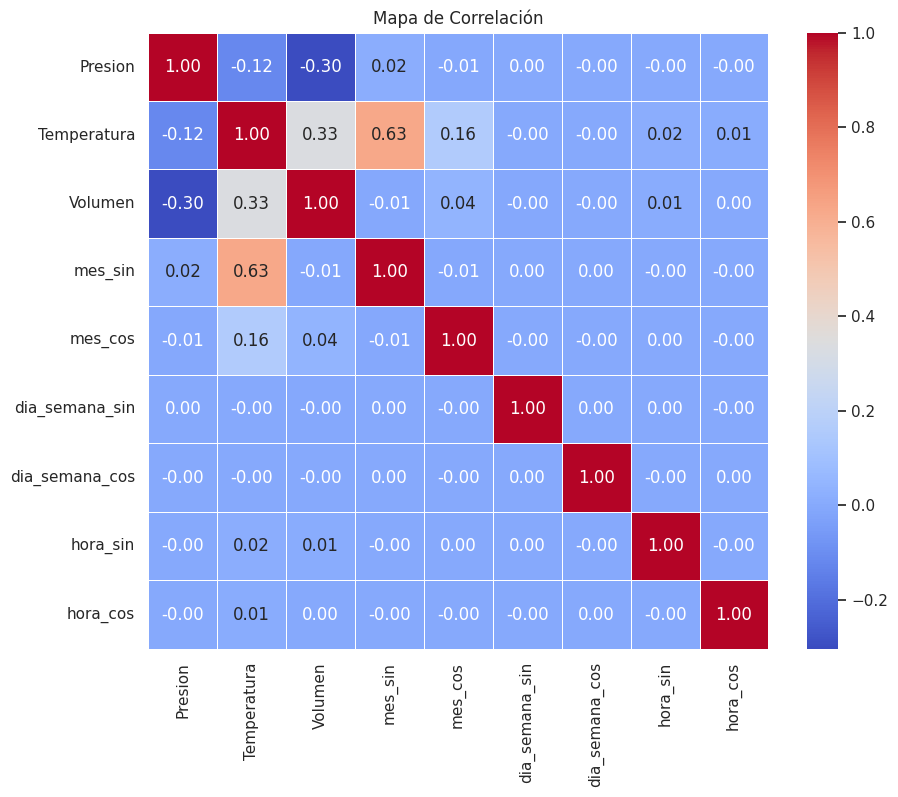

In [ ]:
correlacion = DF_Final_1.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Mapa de Correlación')
plt.show()

# 4. Construcción de Modelos Analíticos para Detección de Anomalías


***Preparación de los Datos***

In [ ]:
# ===========================================
# Preparación de datos
# ===========================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split



In [ ]:

# 1. Selección de variables
features = [
    'Presion', 'Temperatura', 'Volumen',
    'mes_sin', 'mes_cos',
    'dia_semana_sin', 'dia_semana_cos',
    'hora_sin', 'hora_cos'
]

# 2. Crear df_modelo incluyendo la Fecha
df_modelo = DF_Final_1.copy()
df_modelo['Fecha'] = datos_completos['Fecha']  # Asegúrate que 'datos_completos' tenga Fecha

# 3. Crear una versión escalada para modelar
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_modelo_scaled = df_modelo.copy()
df_modelo_scaled[features] = scaler.fit_transform(df_modelo[features])

# 4. Incluir Fecha para visualizaciones pequeña escala
DF_Final_1['Fecha'] = datos_completos['Fecha']
df_prueba = DF_Final_1[['Fecha'] + features].sample(frac=0.1, random_state=42)
df_prueba = DF_Final_1[['Fecha'] + features].sample(frac=0.1, random_state=42)



***Verificación de Supuestos***
> La verificación de supuestos es un paso necesario antes de aplicar modelos analíticos.  
> Permite asegurar que los datos cumplen con las condiciones mínimas requeridas (tipo de datos, ausencia de valores nulos, variabilidad suficiente), lo que garantiza resultados más confiables y evita errores durante la ejecución del modelo.


In [ ]:
# 1. Verificar tipos de datos
print("Tipos de datos en df_modelo:")
print(df_modelo.dtypes)
print("\n---\n")

# 2. Verificar existencia de valores nulos
print("Valores nulos en df_modelo:")
print(df_modelo.isnull().sum())
print("\n---\n")

# 3. Verificar estadísticas descriptivas
print("Estadísticas básicas de las variables:")
print(df_modelo.describe())
print("\n---\n")

# 4. Verificar varianza de las variables
datos_numericos = datos_completos.select_dtypes(include=['number'])
print("Varianza de cada variable:")
print(datos_numericos.var())
print("\n---\n")

# 5. (Opcional) Verificar tamaño del dataset
print(f"Número de registros: {df_modelo.shape[0]}")
print(f"Número de variables: {df_modelo.shape[1]}")


Tipos de datos en df_modelo:
Presion                  float64
Temperatura              float64
Volumen                  float64
Cliente                   object
mes_sin                  float64
mes_cos                  float64
dia_semana_sin           float64
dia_semana_cos           float64
hora_sin                 float64
hora_cos                 float64
Fecha             datetime64[ns]
dtype: object

---

Valores nulos en df_modelo:
Presion           0
Temperatura       0
Volumen           0
Cliente           0
mes_sin           0
mes_cos           0
dia_semana_sin    0
dia_semana_cos    0
hora_sin          0
hora_cos          0
Fecha             0
dtype: int64

---

Estadísticas básicas de las variables:
             Presion    Temperatura        Volumen       mes_sin  \
count  847960.000000  847960.000000  847960.000000  8.479600e+05   
mean       16.072957      25.198239      62.328206 -4.298058e-03   
min         2.934873      -5.257899       0.000000 -1.000000e+00   
25%       

In [ ]:


# ===========================================
# Funciones para ejecución de modelos de detección de anomalías
# ===========================================

# --- 3.1 Isolation Forest ---
def correr_isolation_forest(df, features, contamination=0.05):
    df_local = df.copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_local[features])
    modelo = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    df_local['anomaly'] = modelo.fit_predict(X_scaled)
    df_local['anomaly'] = df_local['anomaly'].apply(lambda x: 1 if x == -1 else 0)
    return df_local, modelo

def evaluar_modelo_isolation(df, vol_col='Volumen'):
    X = df[[vol_col, 'Presion', 'Temperatura']].copy()
    X_scaled = StandardScaler().fit_transform(X)
    silhouette = silhouette_score(X_scaled, df['anomaly']) if df['anomaly'].nunique() > 1 else None
    return {
        'Modelo': 'Isolation Forest',
        '% Anomalías': round(df['anomaly'].mean() * 100, 2),
        'Vol. Anómalo': round(df[df['anomaly'] == 1][vol_col].mean(), 2),
        'Vol. Normal': round(df[df['anomaly'] == 0][vol_col].mean(), 2),
        'Silhouette': round(silhouette, 3) if silhouette else 'N/A'
    }

# --- 3.2 DBSCAN ---
def correr_dbscan(df, features, eps=0.7, min_samples=20):
    df_local = df.copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_local[features])
    modelo = DBSCAN(eps=eps, min_samples=min_samples)
    df_local['cluster'] = modelo.fit_predict(X_scaled)
    df_local['anomaly'] = df_local['cluster'].apply(lambda x: 1 if x == -1 else 0)
    return df_local, modelo

def evaluar_modelo_dbscan(df, vol_col='Volumen'):
    silhouette = silhouette_score(StandardScaler().fit_transform(df[[vol_col, 'Presion', 'Temperatura']]),
                                  df['anomaly']) if df['anomaly'].nunique() > 1 else None
    return {
        'Modelo': 'DBSCAN',
        '% Anomalías': round(df['anomaly'].mean() * 100, 2),
        'Vol. Anómalo': round(df[df['anomaly'] == 1][vol_col].mean(), 2),
        'Vol. Normal': round(df[df['anomaly'] == 0][vol_col].mean(), 2),
        'Silhouette': round(silhouette, 3) if silhouette else 'N/A'
    }

# --- 3.3 Autoencoder ---
def correr_autoencoder(df, features, threshold_percentile=95):
    df_local = df.copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_local[features])
    X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_scaled.shape[1],), kernel_regularizer=regularizers.l2(0.01)),
        Dense(8, activation='relu'),
        Dense(16, activation='relu'),
        Dense(X_scaled.shape[1], activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_val, X_val), verbose=0)

    X_pred = model.predict(X_scaled)
    mse = np.mean(np.square(X_scaled - X_pred), axis=1)
    threshold = np.percentile(mse, threshold_percentile)
    df_local['anomaly'] = (mse > threshold).astype(int)
    return df_local, model

def evaluar_modelo_autoencoder(df, vol_col='Volumen'):
    silhouette = silhouette_score(StandardScaler().fit_transform(df[[vol_col, 'Presion', 'Temperatura']]),
                                  df['anomaly']) if df['anomaly'].nunique() > 1 else None
    return {
        'Modelo': 'Autoencoder',
        '% Anomalías': round(df['anomaly'].mean() * 100, 2),
        'Vol. Anómalo': round(df[df['anomaly'] == 1][vol_col].mean(), 2),
        'Vol. Normal': round(df[df['anomaly'] == 0][vol_col].mean(), 2),
        'Silhouette': round(silhouette, 3) if silhouette else 'N/A'
    }




***Proceso Experimental a Pequeña Escala***

Total de registros en subconjunto de prueba: 84796


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2650/2650 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Columnas en Isolation Forest (test): ['Presion', 'Temperatura', 'Volumen', 'Cliente', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'hora_sin', 'hora_cos', 'Fecha', 'anomaly']

Columnas en DBSCAN (test): ['Presion', 'Temperatura', 'Volumen', 'Cliente', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'hora_sin', 'hora_cos', 'Fecha', 'cluster', 'anomaly']

Columnas en Autoencoder (test): ['Presion', 'Temperatura', 'Volumen', 'Cliente', 'mes_sin', 'mes_cos', 'dia_semana_sin', 'dia_semana_cos', 'hora_sin', 'hora_cos', 'Fecha', 'anomaly']

Evaluación Isolation Forest: {'Modelo': 'Isolation Forest', '% Anomalías': np.float64(5.0), 'Vol. Anómalo': np.float64(135.04), 'Vol. Normal': np.float64(58.58), 'Silhouette': np.float64(0.464)}

Evaluación DBSCAN: {'Modelo': 'DBSCAN', '% Anomalías': np.float64(25.85), 'Vol. Anómalo': np.float64(139.07), 'Vol. Normal': np.float64(35.68), 'Silhouette': np.float64(0.34)}

Evaluación Autoencod

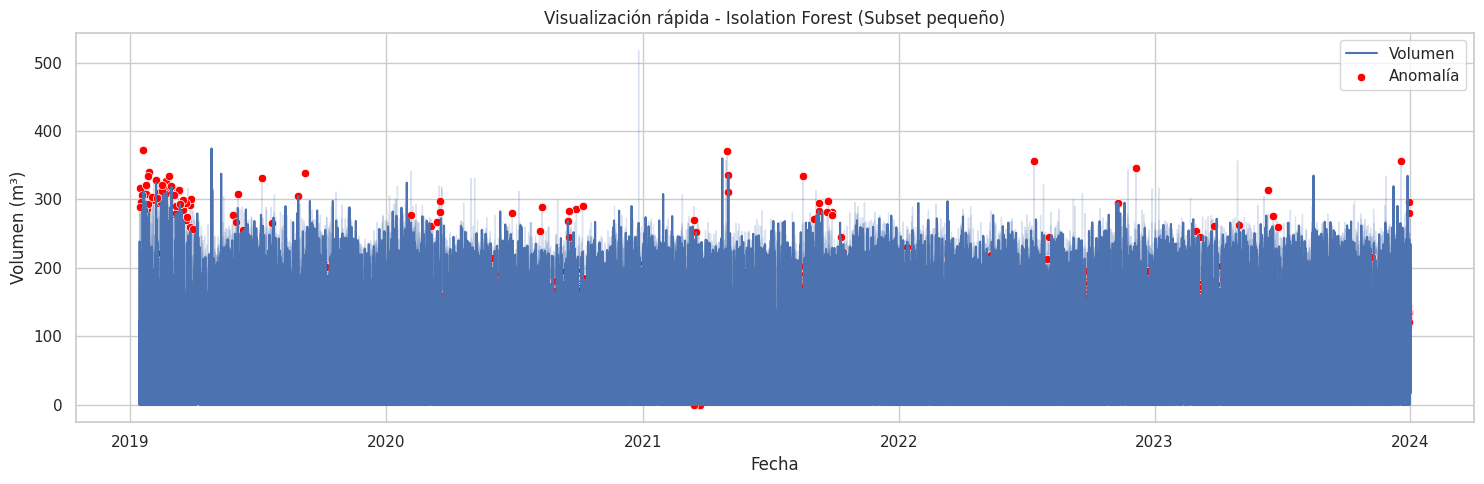

In [ ]:
# 1. Crear subconjunto de datos pequeño
df_prueba = df_modelo.sample(frac=0.1, random_state=42)
print(f"Total de registros en subconjunto de prueba: {len(df_prueba)}")

# 2. Ejecutar modelos sobre el subconjunto

# Isolation Forest
df_iso_test, modelo_iso_test = correr_isolation_forest(df_prueba, features)

# DBSCAN
df_dbscan_test, modelo_dbscan_test = correr_dbscan(df_prueba, features, eps=0.5, min_samples=10)

# Autoencoder
df_auto_test, modelo_auto_test = correr_autoencoder(df_prueba, features)

# 3. Validar generación de columnas
print("\nColumnas en Isolation Forest (test):", df_iso_test.columns.tolist())
print("\nColumnas en DBSCAN (test):", df_dbscan_test.columns.tolist())
print("\nColumnas en Autoencoder (test):", df_auto_test.columns.tolist())

# 4. Evaluar resultados preliminares
print("\nEvaluación Isolation Forest:", evaluar_modelo_isolation(df_iso_test))
print("\nEvaluación DBSCAN:", evaluar_modelo_dbscan(df_dbscan_test))
print("\nEvaluación Autoencoder:", evaluar_modelo_autoencoder(df_auto_test))



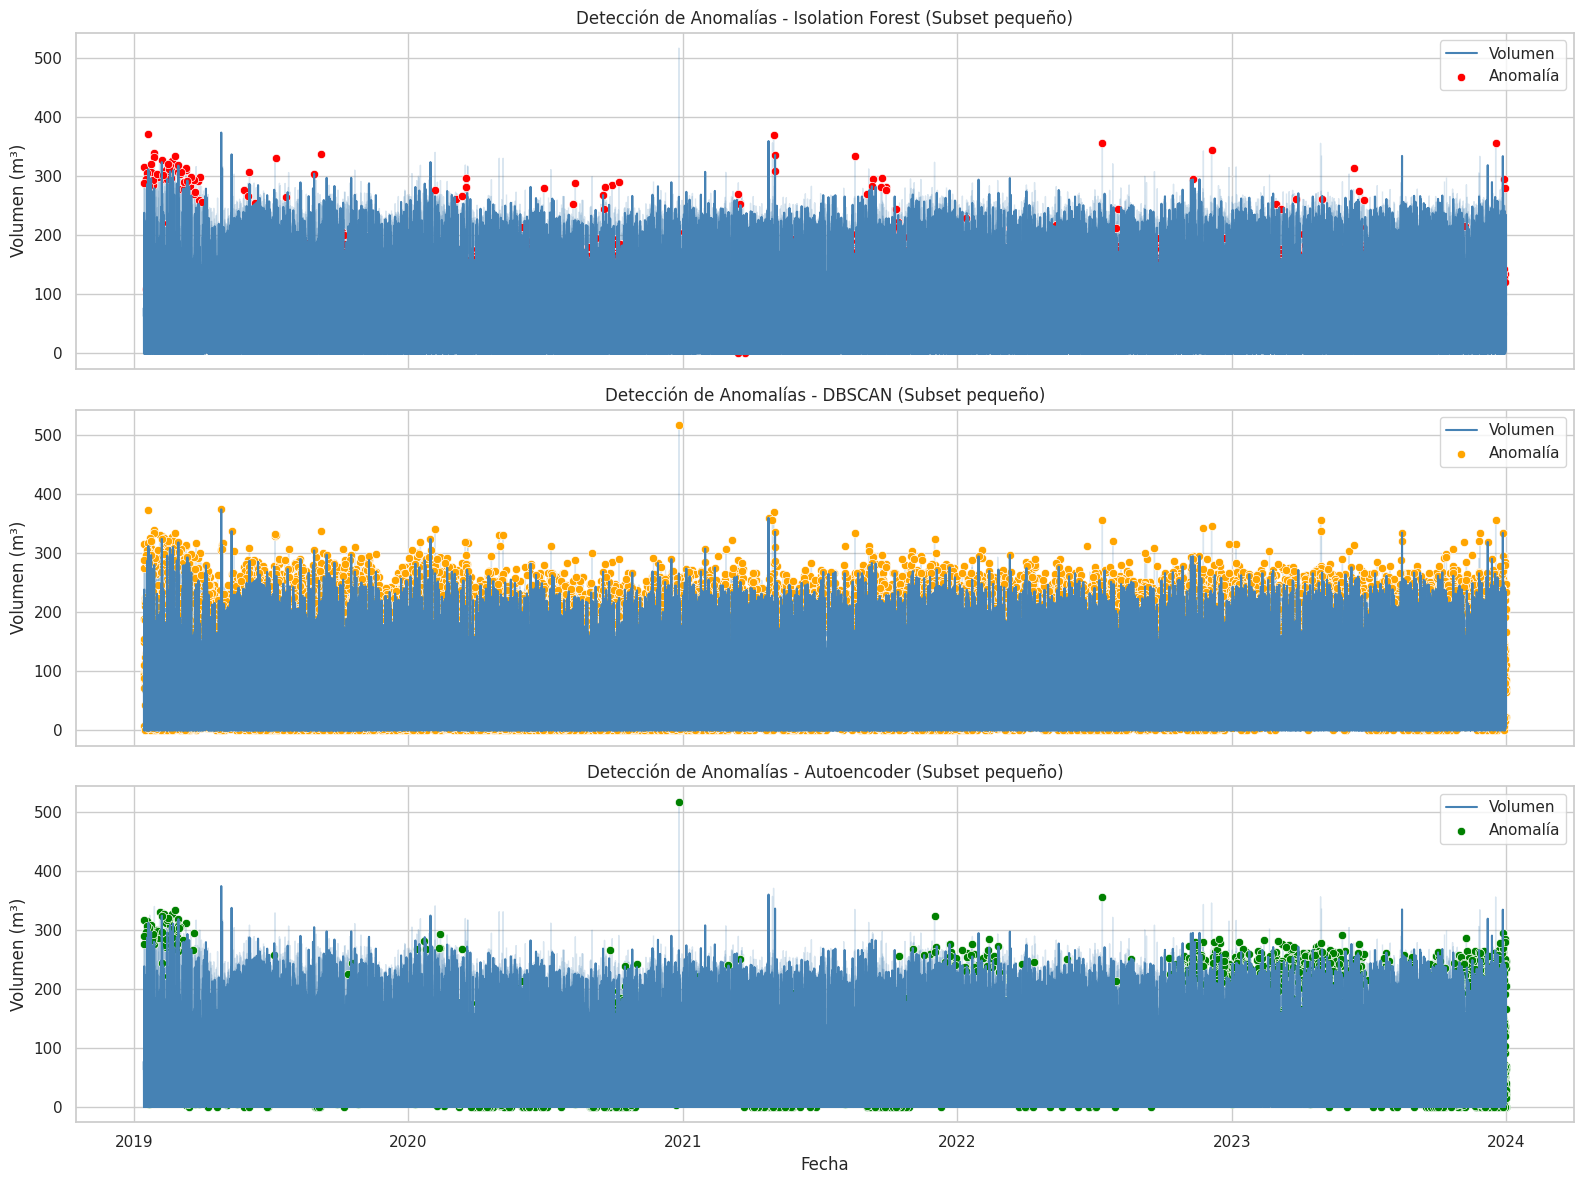

In [ ]:
# 5. Visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar tamaño general de figuras
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# --- Isolation Forest ---
sns.lineplot(ax=axes[0], x='Fecha', y='Volumen', data=df_iso_test, label='Volumen', color='steelblue')
sns.scatterplot(ax=axes[0], x='Fecha', y='Volumen', data=df_iso_test[df_iso_test['anomaly'] == 1], color='red', label='Anomalía')
axes[0].set_title('Detección de Anomalías - Isolation Forest (Subset pequeño)')
axes[0].set_ylabel('Volumen (m³)')
axes[0].legend()

# --- DBSCAN ---
sns.lineplot(ax=axes[1], x='Fecha', y='Volumen', data=df_dbscan_test, label='Volumen', color='steelblue')
sns.scatterplot(ax=axes[1], x='Fecha', y='Volumen', data=df_dbscan_test[df_dbscan_test['anomaly'] == 1], color='orange', label='Anomalía')
axes[1].set_title('Detección de Anomalías - DBSCAN (Subset pequeño)')
axes[1].set_ylabel('Volumen (m³)')
axes[1].legend()

# --- Autoencoder ---
sns.lineplot(ax=axes[2], x='Fecha', y='Volumen', data=df_auto_test, label='Volumen', color='steelblue')
sns.scatterplot(ax=axes[2], x='Fecha', y='Volumen', data=df_auto_test[df_auto_test['anomaly'] == 1], color='green', label='Anomalía')
axes[2].set_title('Detección de Anomalías - Autoencoder (Subset pequeño)')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Volumen (m³)')
axes[2].legend()

plt.tight_layout()
plt.show()

> **Resultado Operativo de la Validación a Pequeña Escala:**  
> La ejecución de los modelos sobre un subconjunto de datos fue exitosa.  
> Se generaron correctamente las columnas esperadas, los resultados son consistentes y el flujo está listo para ser escalado al conjunto de datos completo.


***Escalamiento a todo el dataset***

In [ ]:
# 1. Usar el 100% del dataset
df_sample = df_modelo.copy()

# 2. Reiniciar la lista de evaluación
eval_list = []

In [ ]:

# 3. Correr modelos y evaluar

# Isolation Forest
df_iso, modelo_iso = correr_isolation_forest(df_sample, features, contamination=0.05)
eval_list.append(evaluar_modelo_isolation(df_iso))

# DBSCAN
df_dbscan, modelo_db = correr_dbscan(df_sample, features, eps=0.5, min_samples=10)
eval_list.append(evaluar_modelo_dbscan(df_dbscan))

# Autoencoder
df_auto, modelo_ae = correr_autoencoder(df_sample, features, threshold_percentile=95)
eval_list.append(evaluar_modelo_autoencoder(df_auto))


In [ ]:
# 4. Consolidar comparación
df_comparacion = pd.DataFrame(eval_list)
print(df_comparacion)

# 5. Exportar comparación
df_comparacion.to_excel('comparacion_modelos_final.xlsx', index=False)

             Modelo  % Anomalías  Vol. Anómalo  Vol. Normal  Silhouette
0  Isolation Forest          5.0        126.89        58.84       0.465
1            DBSCAN          5.7        127.88        58.28       0.264
2       Autoencoder          5.0         62.28        62.24       0.110


**Comparación de Resultados de los Modelos**

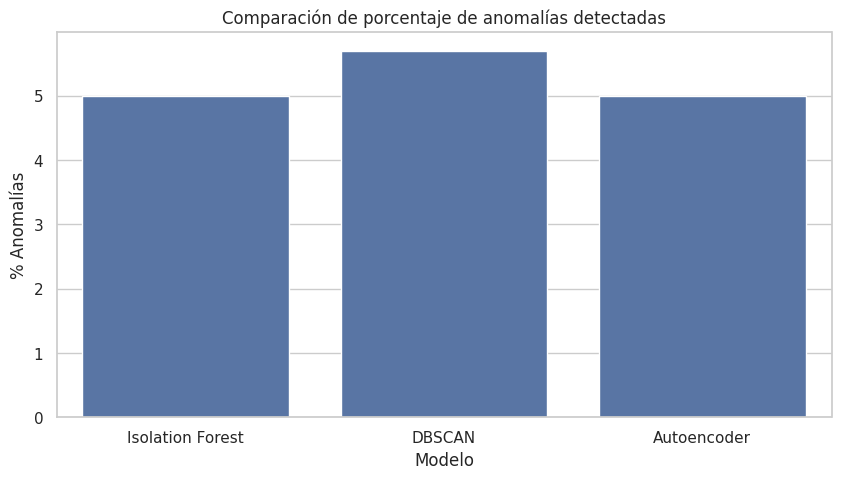

In [ ]:
# ===========================================
# Visualización comparativa
# ===========================================

plt.figure(figsize=(10, 5))
sns.barplot(x='Modelo', y='% Anomalías', data=df_comparacion)
plt.title('Comparación de porcentaje de anomalías detectadas')
plt.ylabel('% Anomalías')
plt.show()

# ===========================================
# 5. Exportación
# ===========================================
df_comparacion.to_excel('comparacion_modelos_anomalias.xlsx', index=False)

**Visualización General de Anomalías**

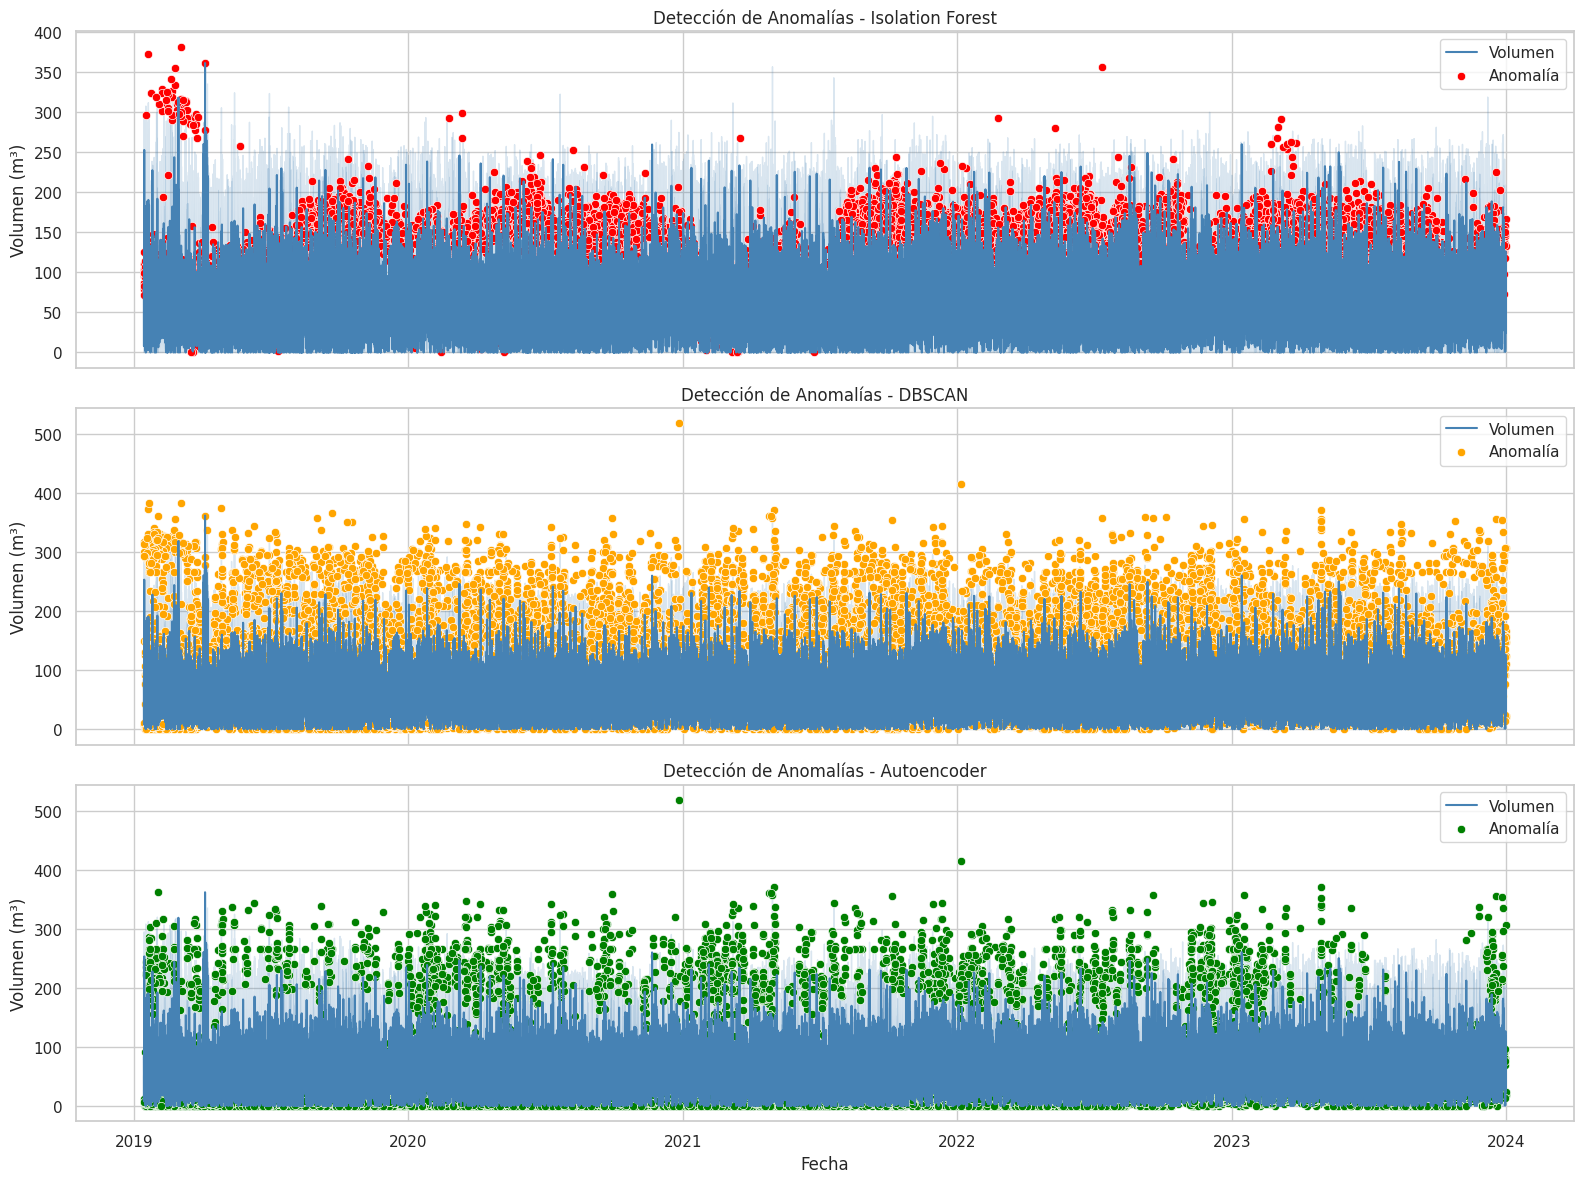

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# --- Isolation Forest ---
sns.lineplot(ax=axes[0], x='Fecha', y='Volumen', data=df_iso, label='Volumen', color='steelblue')
sns.scatterplot(ax=axes[0], x='Fecha', y='Volumen', data=df_iso[df_iso['anomaly'] == 1], color='red', label='Anomalía')
axes[0].set_title('Detección de Anomalías - Isolation Forest')
axes[0].set_ylabel('Volumen (m³)')
axes[0].legend()

# --- DBSCAN ---
sns.lineplot(ax=axes[1], x='Fecha', y='Volumen', data=df_dbscan, label='Volumen', color='steelblue')
sns.scatterplot(ax=axes[1], x='Fecha', y='Volumen', data=df_dbscan[df_dbscan['anomaly'] == 1], color='orange', label='Anomalía')
axes[1].set_title('Detección de Anomalías - DBSCAN')
axes[1].set_ylabel('Volumen (m³)')
axes[1].legend()

# --- Autoencoder ---
sns.lineplot(ax=axes[2], x='Fecha', y='Volumen', data=df_auto, label='Volumen', color='steelblue')
sns.scatterplot(ax=axes[2], x='Fecha', y='Volumen', data=df_auto[df_auto['anomaly'] == 1], color='green', label='Anomalía')
axes[2].set_title('Detección de Anomalías - Autoencoder')
axes[2].set_xlabel('Fecha')
axes[2].set_ylabel('Volumen (m³)')
axes[2].legend()

plt.tight_layout()
plt.show()


## 5. Conclusiones Resultados de Modelos

**Conclusiones a partir de las métricas**


### 1. Porcentaje de Anomalías Detectadas
- Todos los modelos detectaron entre **5% y 5.7%** de los puntos como anómalos.
- Esto es consistente y esperado, dado que el parámetro `contamination` o el umbral (en Autoencoder) fue configurado para ese rango.

### 2. Volumen Promedio (Anómalo vs Normal)
- **Isolation Forest** y **DBSCAN** capturan puntos anómalos con un volumen **significativamente superior** al volumen normal (**126–127** vs **58**).
  - Esto sugiere que estos modelos están detectando picos de consumo o eventos extremos.
- **Autoencoder** no muestra una diferencia marcada (**62** vs **62**), lo que puede indicar:
  - Sobreajuste o subentrenamiento del modelo.
  - Dificultad para diferenciar entre patrones normales y anómalos con su configuración actual.

### 3. Silhouette Score
- Esta métrica mide qué tan bien separados están los grupos detectados como normales y anómalos.
- Resultados:
  - **Isolation Forest**: **0.465** → buena separación.
  - **DBSCAN**: **0.264** → separación aceptable.
  - **Autoencoder**: **0.110** → muy baja separabilidad, indicando confusión entre clases.





**Conclusiones basadas en la Visualización de Anomalías**

### 1. Isolation Forest
- El modelo detecta anomalías claramente agrupadas en ciertos periodos (picos reales en el volumen).
- Se comporta de manera **selectiva**:
  - Hay días con anomalías, pero también días completamente normales.
  - Esto indica que **no está sobreajustado** ni genera falsos positivos constantemente.

### 2. DBSCAN
- El modelo marca anomalías **prácticamente todos los días**.
- Puede estar interpretando como “ruido” comportamientos normales que presentan **alta variabilidad diaria**.
- Esto sugiere que:
  - Hay **mucha dispersión natural** en los datos.
  - El modelo DBSCAN podría requerir un ajuste de los parámetros `eps` y `min_samples` para disminuir la sensibilidad.

### 3. Autoencoder
- Muestra una frecuencia de detección de anomalías **similar a Isolation Forest**, pero:
  - Detecta **eventos más aislados** y algunos **picos extremos** más dispersos.
- Indica que:
  - Reconoce bien los outliers.
  - Sin embargo, podría ser menos consistente en la detección de patrones estructurados a lo largo del tiempo.




# Conclusión General

A partir de los resultados de las métricas y del análisis visual de las anomalías detectadas, se concluye que:

- **Isolation Forest** es el modelo que demuestra **mejor desempeño global** para la detección de anomalías en el consumo de gas.  
  Esto se refleja en su capacidad para:
  - Detectar anomalías asociadas a cambios significativos en el volumen.
  - Presentar la **mejor separación** entre comportamientos normales y anómalos, según el Silhouette Score.
  - Mantener un **comportamiento estable y consistente** a lo largo del tiempo, capturando picos reales y respetando la normalidad en días regulares.

- **DBSCAN**, aunque útil en ciertos contextos, mostró **una sensibilidad excesiva** bajo su configuración actual, detectando anomalías prácticamente todos los días, lo que podría generar falsos positivos y sobrecargar los procesos operativos.

- **Autoencoder**, en su arquitectura y configuración actual, **no logra diferenciar adecuadamente** entre comportamientos normales y anómalos.  
  Su detección es más dispersa y muestra menor capacidad de separación, tanto en las métricas como en la visualización temporal.

---


Con base en el análisis técnico y visual realizado, **se selecciona el modelo Isolation Forest para su ajuste fino y optimización** en la siguiente etapa del proyecto.

El objetivo será potenciar su desempeño a través de la calibración de sus hiperparámetros, garantizando una detección precisa, robusta y operativamente útil.


In [ ]:
# ===========================================
# Generar dataset final de predicciones
# ===========================================

# Seleccionar el mejor modelo - Isolation Forest (por resultados)
# Crear el DataFrame final de reporte

df_resultado_final = df_iso.copy()

# Asegurar que esté 'Fecha', 'Volumen' y 'anomaly' para análisis
df_resultado_final = df_resultado_final[['Fecha', 'Volumen', 'anomaly']]

# 7. Exportar resultados de anomalías
df_resultado_final.to_excel('anomalías_detectadas_final.xlsx', index=False)

print("Proceso completo finalizado. Resultados exportados.")

# **Parte 2. Optimización del Modelo de Detección de Anomalías**

De acuerdo con los resultados obtenidos en la Parte 1, el modelo Isolation Forest fue seleccionado como el modelo más adecuado para la detección de anomalías en los datos de consumo de gas, debido a su capacidad de discriminación, estabilidad y coherencia con los patrones esperados.

Por lo tanto, en esta Parte 2, se desarrollarán experimentos exhaustivos enfocados únicamente en Isolation Forest, con el objetivo de:

- Ajustar y optimizar sus hiperparámetros (`contamination`, `n_estimators`).
- Evaluar el impacto de diferentes configuraciones sobre las métricas clave (% de anomalías detectadas, Volumen anómalo, Silhouette Score).
- Seleccionar la mejor combinación de parámetros.
- Reentrenar y validar el modelo optimizado sobre todo el dataset.



# 1. Implementación de Experimentos

In [ ]:


# Ajuste de parámetros para Isolation Forest


# Definir los valores de hiperparámetros a probar
contamination_vals = [0.01, 0.03, 0.05, 0.08]
n_estimators_vals = [50, 100, 150]

# Crear lista para guardar resultados
experiment_results_iforest = []

# Loop de experimentación
for contamination in contamination_vals:
    for n_estimators in n_estimators_vals:

        # Entrenar modelo con combinación de parámetros
        model = IsolationForest(
            n_estimators=n_estimators,
            contamination=contamination,
            random_state=42
        )

        # Solo trabajar sobre features escalados
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df_modelo[features])

        preds = model.fit_predict(X_scaled)

        # Crear DataFrame temporal para evaluar
        df_temp = df_modelo.copy()
        df_temp['anomaly'] = (preds == -1).astype(int)

        # Evaluar resultados
        eval_ = evaluar_modelo_isolation(df_temp)
        eval_['contamination'] = contamination
        eval_['n_estimators'] = n_estimators

        experiment_results_iforest.append(eval_)

# Consolidar resultados en DataFrame
df_experimentos_iforest = pd.DataFrame(experiment_results_iforest)

# Mostrar resultados
print(df_experimentos_iforest)

# Guardar resultados
df_experimentos_iforest.to_excel('resultados_experimentos_isolation_forest.xlsx', index=False)


# 2. Visualización de Resultados

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Curva Silhouette Score vs Contamination
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_experimentos_iforest, x='contamination', y='Silhouette', hue='n_estimators', marker='o')
plt.title('Silhouette Score vs Contamination por n_estimators')
plt.ylabel('Silhouette Score')
plt.xlabel('Contamination')
plt.legend(title='n_estimators')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 2. Curva % de Anomalías vs Contamination
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_experimentos_iforest, x='contamination', y='% Anomalías', hue='n_estimators', marker='o')
plt.title('% de Anomalías Detectadas vs Contamination por n_estimators')
plt.ylabel('% Anomalías')
plt.xlabel('Contamination')
plt.legend(title='n_estimators')
plt.grid(True)
plt.tight_layout()
plt.show()